In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd
from sympy import Symbol
from sympy.solvers import solve
import sympy as sp

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res


# Set experiment(s) to analyze


In [3]:
# Closed Loop dataset, excluding when AAS did not kick in
exp_ids=[#'2018_04_17_10_58_11_780A Ramsey between r1-r2',
         #'2018_04_17_11_26_58_780A Ramsey between r1-r2',
         #'2018_04_17_12_16_21_780A Ramsey between r1-r2',
         '2018_04_17_12_52_32_780A Ramsey between r1-r2',
         '2018_04_17_16_21_34_780A ramsey',
         #'2018_04_17_21_12_34_780A ramsey',
         #'2018_04_17_21_56_12_780A ramsey',
         #'2018_04_17_22_53_53_780A ramsey',
         '2018_04_18_09_49_23_780A ramsey',
         '2018_04_18_09_49_23_780A ramsey',
         '2018_04_18_10_54_00_780A ramsey',
         '2018_04_18_11_42_28_780A ramsey',
         #'2018_04_18_19_49_00_780A ramsey, closed loop',
         #'2018_04_18_20_29_56_780A ramsey, closed loop',
         #'2018_04_18_21_20_52_780A ramsey, closed loop',
         #'2018_04_18_22_11_27_780A ramsey, closed loop',
         '2018_04_19_11_01_05_780A ramsey, closed loop',
         '2018_04_19_15_18_27_780A ramsey, closed loop',
         '2018_04_19_15_43_07_780A ramsey, closed loop',
         '2018_04_19_16_03_22_780A ramsey, closed loop',
         '2018_04_19_16_23_37_780A ramsey, closed loop',
         '2018_04_19_16_46_21_780A ramsey, closed loop',
         '2018_04_19_17_30_17_780A ramsey, closed loop',
         '2018_04_19_22_47_43_780A ramsey, closed loop',
         '2018_04_19_23_20_45_780A ramsey, closed loop',
         '2018_04_19_23_50_26_780A ramsey, closed loop',
         '2018_04_20_00_18_45_780A ramsey, closed loop',
         '2018_04_20_00_44_51_780A ramsey, closed loop',
#          '2018_04_20_02_03_45_780A ramsey, closed loop',
         '2018_04_20_08_32_02_780A ramsey, closed loop',
         '2018_04_20_09_20_41_780A ramsey, closed loop',
         '2018_04_20_10_49_28_780A ramsey, closed loop',
         '2018_04_20_11_47_15_780A ramsey, closed loop',
         '2018_04_20_12_26_31_780A ramsey, closed loop',
         '2018_04_20_13_07_25_780A ramsey, closed loop',
         '2018_04_20_13_49_08_780A ramsey, closed loop',
         '2018_04_20_14_27_42_780A ramsey, closed loop',
         '2018_04_20_14_51_43_780A ramsey, closed loop',
         '2018_04_20_15_21_04_780A ramsey, closed loop',
         '2018_04_20_15_44_45_780A ramsey, closed loop',
         '2018_04_20_16_05_33_780A ramsey, closed loop',
         '2018_04_20_16_23_49_780A ramsey, closed loop',
         '2018_04_20_16_40_40_780A ramsey, closed loop',
         '2018_04_20_17_23_53_780A ramsey, closed loop',
         '2018_04_20_18_10_59_780A ramsey, closed loop',
         '2018_04_20_19_40_13_780A ramsey, closed loop',
         '2018_04_20_20_20_52_780A ramsey, closed loop',
         #'2018_04_21_14_01_47_780A ramsey, closed loop',
         #'2018_04_21_14_39_59_780A ramsey, closed loop',
         #'2018_04_21_15_14_06_780A ramsey, closed loop',
         '2018_04_21_15_47_33_780A ramsey, closed loop',
         '2018_04_21_18_53_41_780A ramsey, closed loop',
         '2018_04_21_19_12_49_780A ramsey, closed loop',
         '2018_04_21_19_33_26_780A ramsey, closed loop',
         '2018_04_21_19_55_13_780A ramsey, closed loop',
         '2018_04_21_20_16_19_780A ramsey, closed loop',
         '2018_04_21_20_36_32_780A ramsey, closed loop',
         '2018_04_21_21_01_09_780A ramsey, closed loop',
         '2018_04_21_21_19_05_780A ramsey, closed loop',
         '2018_04_21_21_46_30_780A ramsey, closed loop',
         '2018_04_21_22_12_15_780A ramsey, closed loop',
        '2018_04_21_22_39_47_780A ramsey, closed loop',
    '2018_04_21_23_03_01_780A ramsey, closed loop',
    '2018_04_21_23_26_30_780A ramsey, closed loop',
    '2018_04_21_23_50_06_780A ramsey, closed loop',
    '2018_04_22_00_15_48_780A ramsey, closed loop',
    '2018_04_22_01_07_55_780A ramsey, closed loop',
    '2018_04_22_01_32_59_780A ramsey, closed loop',
    '2018_04_22_01_56_39_780A ramsey, closed loop',
    '2018_04_22_12_40_38_780A ramsey, closed loop',
    '2018_04_22_13_25_53_780A ramsey, closed loop',
    '2018_04_22_14_14_58_780A ramsey, closed loop',
    '2018_04_22_14_14_58_780A ramsey, closed loop',
    '2018_04_22_15_13_55_780A ramsey, closed loop',
    '2018_04_22_15_37_22_780A ramsey, closed loop',
    '2018_04_22_16_07_54_780A ramsey, closed loop',
    '2018_04_22_16_41_00_780A ramsey, closed loop',
    '2018_04_22_17_47_18_780A ramsey, closed loop',
    '2018_04_22_19_38_12_780A ramsey, closed loop',
    '2018_04_22_20_20_07_780A ramsey, closed loop',
    '2018_04_22_20_52_17_780A ramsey, closed loop',
    '2018_04_22_21_20_20_780A ramsey, closed loop',
    '2018_04_22_21_51_16_780A ramsey, closed loop',
    '2018_04_22_22_10_44_780A ramsey, closed loop',
    '2018_04_22_22_40_55_780A ramsey, closed loop',
    '2018_04_22_23_08_42_780A ramsey, closed loop',
   # '2018_04_22_23_40_54_780A ramsey, closed loop',
    '2018_04_23_08_26_03_780A ramsey, closed loop',
    '2018_04_23_08_59_01_780A ramsey, closed loop',
    '2018_04_23_09_30_44_780A ramsey, closed loop',
    
        ]

keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
         'AAS_redside',
         'AAS_blueside',
 'timestamp_measurements',
 'timestamp_iteration']

data={}
assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])

#     q=container['qdp_class']
#     for i in q.experiments[e]['iterations']:
#         for key in keylist:
#             if i==0 and j==0:
#                 data[key]=[]
#             try:
#                 data[key].append(q.experiments[e]['iterations'][i][key])
#             except:
#                 print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)
# no atom analyses. Should be able to run single import to do all the jobs

# data={}
# for j in range(0,len(exp_ids)):
#     exp_id=exp_ids[j]
#     q=open_data(exp_id)
#     e=0
#     for i in q.experiments[e]['iterations']:
#         for key in keylist:
#             if i==0 and j==0:
#                 data[key]=[]
#             try:
#                 data[key].append(q.experiments[e]['iterations'][i][key])
#             except:
#                 print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_12_52_32_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_16_21_34_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_18/2018_04_18_09_49_23_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_18/2018_04_18_09_49_23_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_18/2018_04_18_10_54_00_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_18/2018_04_18_11_42_28_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_19/2018_04_19_11_01_05_780A ramsey, closed loop/qdp.txt
Yay! found old qdp class. We

# Experiment-wise analysis

2018_04_17_12_52_32_780A Ramsey between r1-r2
0


<IPython.core.display.Javascript object>


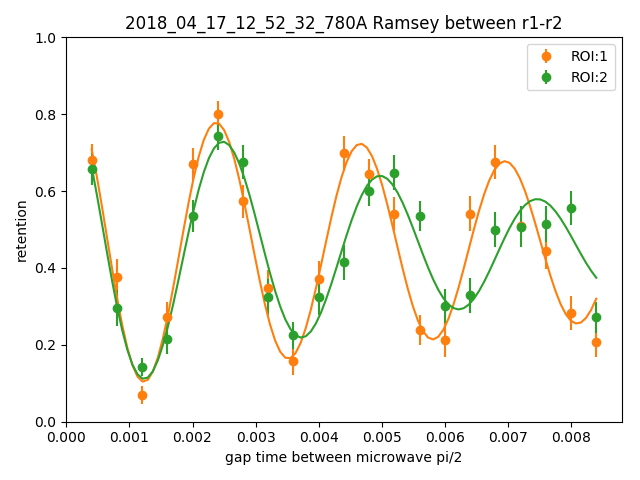

tau 1  is  0.0122500099877  with 1 std of   0.00436372814621
amplitude 1  is  0.390257258883  with 1 std of   0.0483127816333
frequency 1  is  436.720490681  with 1 std of   4.53776953793
phase 1  is  1.31416616499  with 1 std of   0.116946971641
offset 1  is  0.456774524526  with 1 std of   0.0133252090978
tau 2  is  0.00651239819389  with 1 std of   0.00159492932787
amplitude 2  is  0.409351216124  with 1 std of   0.0547603676453
frequency 2  is  401.167243906  with 1 std of   5.30917603867
phase 2  is  1.54397498171  with 1 std of   0.114446324645
offset 2  is  0.449407112982  with 1 std of   0.0124110797706
2018_04_17_16_21_34_780A ramsey
1


<IPython.core.display.Javascript object>


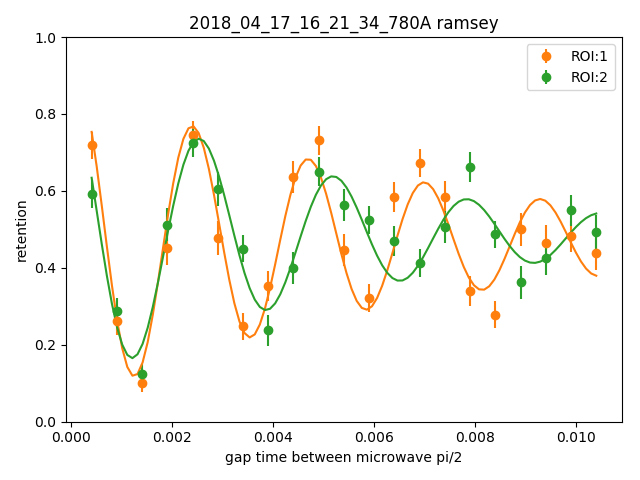

tau 1  is  0.00681548383517  with 1 std of   0.00167999787516
amplitude 1  is  0.423757242821  with 1 std of   0.0615950923511
frequency 1  is  435.196787703  with 1 std of   5.84478818283
phase 1  is  1.2616611167  with 1 std of   0.143319937298
offset 1  is  0.470743860079  with 1 std of   0.014570827752
tau 2  is  0.0053702533996  with 1 std of   0.0012547862999
amplitude 2  is  0.401959098594  with 1 std of   0.0636495114145
frequency 2  is  377.096032072  with 1 std of   6.38894299733
phase 2  is  1.7839250711  with 1 std of   0.132117196347
offset 2  is  0.485561302473  with 1 std of   0.0128329519655
2018_04_18_09_49_23_780A ramsey
2


<IPython.core.display.Javascript object>


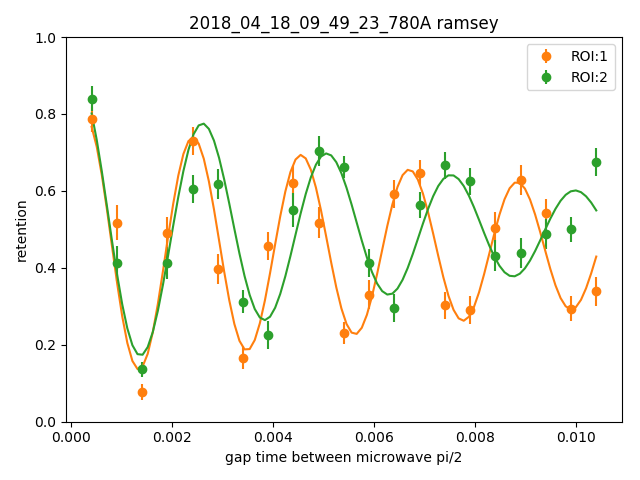

tau 1  is  0.0125078155135  with 1 std of   0.00501442187643
amplitude 1  is  0.350038115948  with 1 std of   0.0531782555533
frequency 1  is  466.888625911  with 1 std of   5.19579563841
phase 1  is  0.767588803548  with 1 std of   0.165486011587
offset 1  is  0.450534151969  with 1 std of   0.0156025889063
tau 2  is  0.00744233756371  with 1 std of   0.00224616435696
amplitude 2  is  0.392898193847  with 1 std of   0.0651446413922
frequency 2  is  406.374981377  with 1 std of   6.50956915718
phase 2  is  1.17138246627  with 1 std of   0.16980166006
offset 2  is  0.498705151037  with 1 std of   0.0161257398936
2018_04_18_09_49_23_780A ramsey
3


<IPython.core.display.Javascript object>


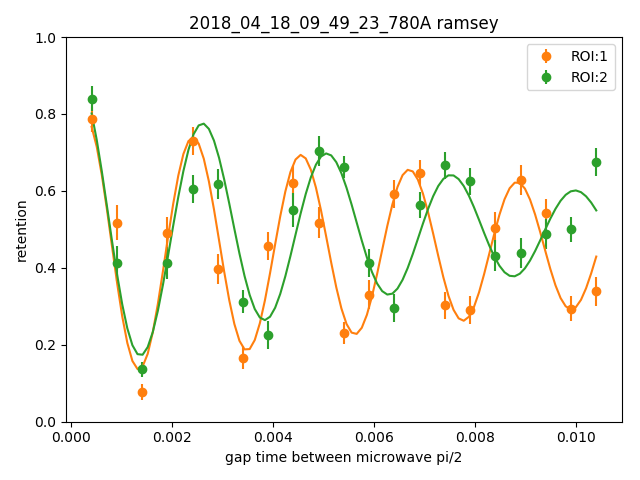

tau 1  is  0.0125078155135  with 1 std of   0.00501442187643
amplitude 1  is  0.350038115948  with 1 std of   0.0531782555533
frequency 1  is  466.888625911  with 1 std of   5.19579563841
phase 1  is  0.767588803548  with 1 std of   0.165486011587
offset 1  is  0.450534151969  with 1 std of   0.0156025889063
tau 2  is  0.00744233756371  with 1 std of   0.00224616435696
amplitude 2  is  0.392898193847  with 1 std of   0.0651446413922
frequency 2  is  406.374981377  with 1 std of   6.50956915718
phase 2  is  1.17138246627  with 1 std of   0.16980166006
offset 2  is  0.498705151037  with 1 std of   0.0161257398936
2018_04_18_10_54_00_780A ramsey
4


<IPython.core.display.Javascript object>


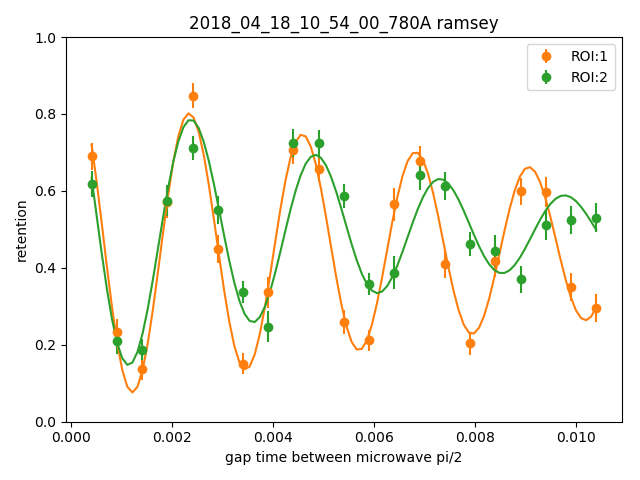

tau 1  is  0.0130992727787  with 1 std of   0.00179520985891
amplitude 1  is  0.415178278965  with 1 std of   0.0218950926818
frequency 1  is  445.566218256  with 1 std of   1.67369436372
phase 1  is  1.30468559336  with 1 std of   0.0514712729991
offset 1  is  0.454474635919  with 1 std of   0.006095302615
tau 2  is  0.00644902913238  with 1 std of   0.00162538144535
amplitude 2  is  0.417550491056  with 1 std of   0.0641780057495
frequency 2  is  405.311746499  with 1 std of   5.4177173937
phase 2  is  1.76991719807  with 1 std of   0.127264626776
offset 2  is  0.496938434102  with 1 std of   0.0137354570773
2018_04_18_11_42_28_780A ramsey
5


<IPython.core.display.Javascript object>


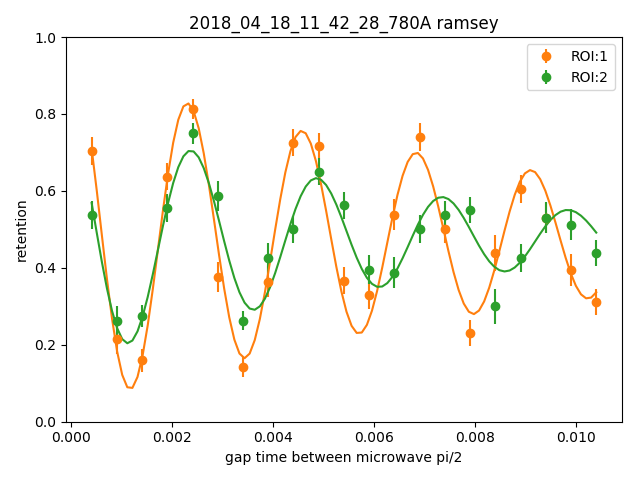

tau 1  is  0.00992893125737  with 1 std of   0.00182891977745
amplitude 1  is  0.441861565222  with 1 std of   0.0386707442176
frequency 1  is  441.030848848  with 1 std of   2.91162388032
phase 1  is  1.45378893811  with 1 std of   0.0819119248463
offset 1  is  0.477653459925  with 1 std of   0.00994107026889
tau 2  is  0.00654498428706  with 1 std of   0.00174487185727
amplitude 2  is  0.326019702778  with 1 std of   0.0527656864033
frequency 2  is  401.533591487  with 1 std of   5.64239098896
phase 2  is  1.83329690817  with 1 std of   0.132922914685
offset 2  is  0.47825056715  with 1 std of   0.0113235223841
2018_04_19_11_01_05_780A ramsey, closed loop
6


<IPython.core.display.Javascript object>


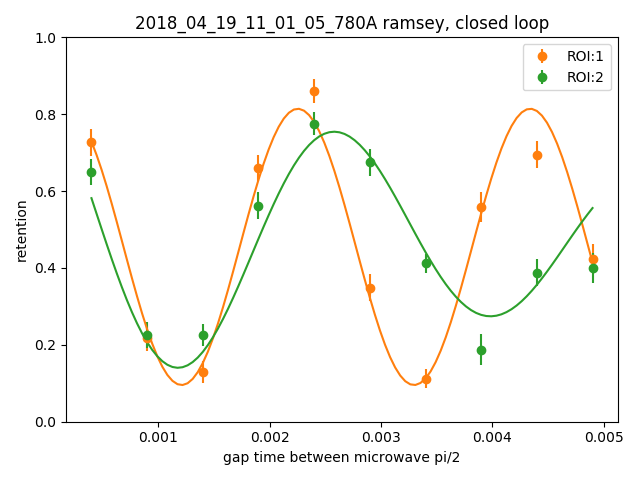

tau 1  is  -320548.573876  with 1 std of   2.63850616933e+12
amplitude 1  is  0.3594266024  with 1 std of   0.0500815890691
frequency 1  is  479.107006542  with 1 std of   8.8240151014
phase 1  is  1.07086915812  with 1 std of   0.176212034093
offset 1  is  0.454809133564  with 1 std of   0.0250356948974
tau 2  is  0.00570139334869  with 1 std of   0.00471315929202
amplitude 2  is  0.424999456112  with 1 std of   0.151665721362
frequency 2  is  356.37450429  with 1 std of   17.808133188
phase 2  is  1.99953960809  with 1 std of   0.257722613309
offset 2  is  0.484979578199  with 1 std of   0.0349130039736
2018_04_19_15_18_27_780A ramsey, closed loop
7


<IPython.core.display.Javascript object>


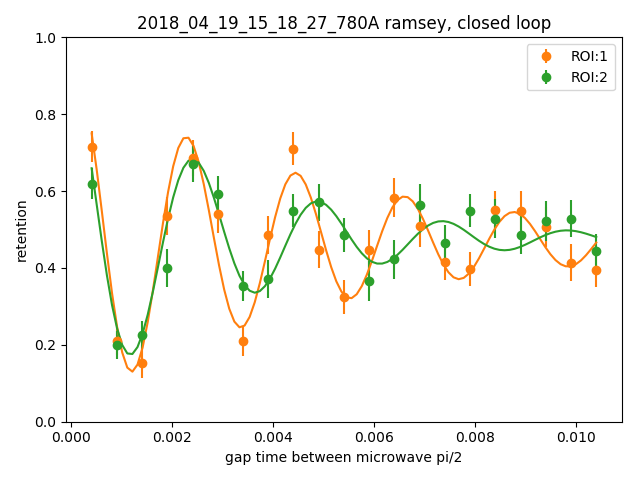

tau 1  is  0.00518697841236  with 1 std of   0.00105104870415
amplitude 1  is  0.425517029752  with 1 std of   0.0562053364026
frequency 1  is  462.415608482  with 1 std of   6.09377494294
phase 1  is  1.17857572514  with 1 std of   0.131084823441
offset 1  is  0.467304868845  with 1 std of   0.0120409917565
tau 2  is  0.00324495406896  with 1 std of   0.000764146122168
amplitude 2  is  0.436302012126  with 1 std of   0.0805982321475
frequency 2  is  404.563653499  with 1 std of   10.2917485603
phase 2  is  1.63164724481  with 1 std of   0.148142393453
offset 2  is  0.476837196984  with 1 std of   0.0122359312884
2018_04_19_15_43_07_780A ramsey, closed loop
8


<IPython.core.display.Javascript object>


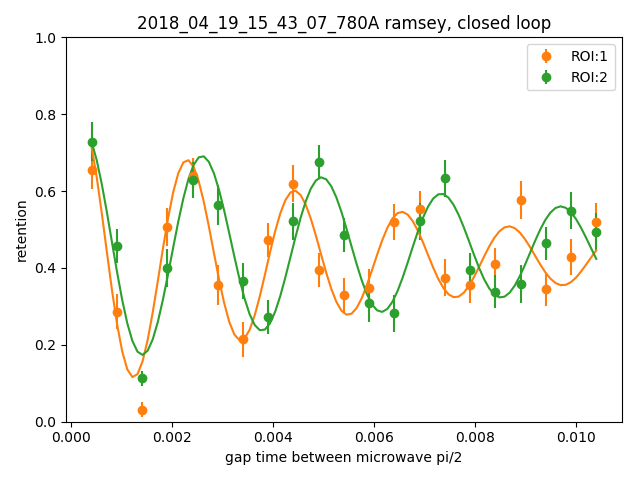

tau 1  is  0.00570130623621  with 1 std of   0.00142165402897
amplitude 1  is  0.384187473732  with 1 std of   0.0592972917828
frequency 1  is  470.528630218  with 1 std of   7.08098214397
phase 1  is  1.01599512065  with 1 std of   0.16310601286
offset 1  is  0.424541210872  with 1 std of   0.0136672439429
tau 2  is  0.00910879152599  with 1 std of   0.00238928544489
amplitude 2  is  0.321833426511  with 1 std of   0.0401803513271
frequency 2  is  421.981192174  with 1 std of   4.60928095942
phase 2  is  0.95298823854  with 1 std of   0.133391893484
offset 2  is  0.449399655879  with 1 std of   0.0108031534658
2018_04_19_16_03_22_780A ramsey, closed loop
9


<IPython.core.display.Javascript object>

tau 1  is  0.004456506572  with 1 std of   0.000888253836221
amplitude 1  is  0.460167463355  with 1 std of   0.063851475708
frequency 1  is  460.490438129  with 1 std of   6.8305442866
phase 1  is  1.28720036264  with 1 std of   0.131179856596
offset 1  is  0.453436689283  with 1 std of   0.012461410194
tau 2  is  0.00440626856093  with 1 std of   0.00127539126463
amplitude 2  is  0.416692194698  with 1 std of   0.0844256961335
frequency 2  is  412.447147973  with 1 std of   10.0006769058
phase 2  is  1.34447669472  with 1 std of   0.191146991221
offset 2  is  0.469688070862  with 1 std of   0.0163064971786
2018_04_19_16_23_37_780A ramsey, closed loop
10


<IPython.core.display.Javascript object>


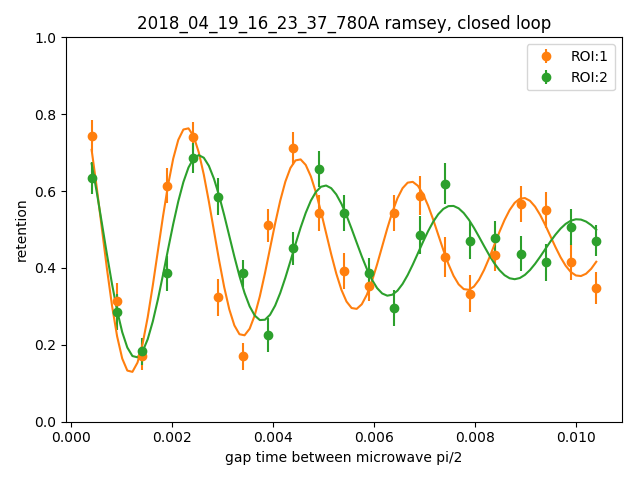

tau 1  is  0.0068239695684  with 1 std of   0.00149805461665
amplitude 1  is  0.409458450022  with 1 std of   0.0527240465505
frequency 1  is  449.617404065  with 1 std of   4.93414242689
phase 1  is  1.35687800715  with 1 std of   0.121053756977
offset 1  is  0.472189084228  with 1 std of   0.0121801456664
tau 2  is  0.00616795644488  with 1 std of   0.00123395772251
amplitude 2  is  0.357542168609  with 1 std of   0.0443665249065
frequency 2  is  399.910907207  with 1 std of   4.97300961591
phase 2  is  1.4411692844  with 1 std of   0.115372588939
offset 2  is  0.456713547422  with 1 std of   0.00983838032337
2018_04_19_16_46_21_780A ramsey, closed loop
11


<IPython.core.display.Javascript object>


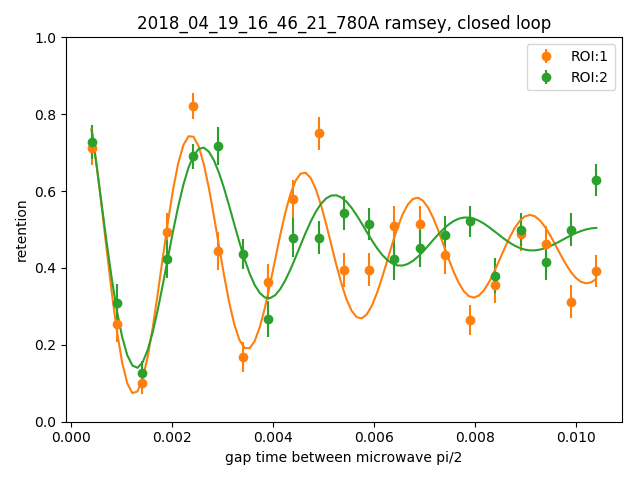

tau 1  is  0.00590021634578  with 1 std of   0.00138196148855
amplitude 1  is  0.455266906315  with 1 std of   0.0666456297368
frequency 1  is  446.265102041  with 1 std of   6.47678981263
phase 1  is  1.16643192771  with 1 std of   0.148683348298
offset 1  is  0.440636564123  with 1 std of   0.0151726108619
tau 2  is  0.00344476041079  with 1 std of   0.000715825271479
amplitude 2  is  0.498556372412  with 1 std of   0.0794618838244
frequency 2  is  382.446923354  with 1 std of   9.20452508223
phase 2  is  1.49926502484  with 1 std of   0.142305373721
offset 2  is  0.480448797367  with 1 std of   0.0131416864014
2018_04_19_17_30_17_780A ramsey, closed loop
12


<IPython.core.display.Javascript object>


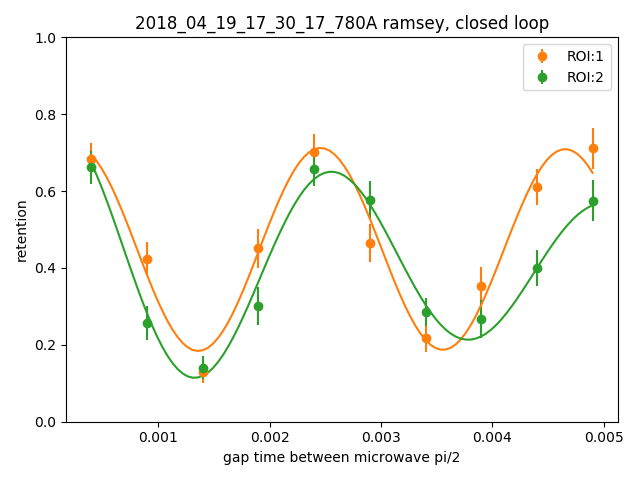

tau 1  is  0.188482193352  with 1 std of   2.40177550178
amplitude 1  is  0.266772772061  with 1 std of   0.0529257193607
frequency 1  is  455.04689019  with 1 std of   12.5480071117
phase 1  is  0.826673217129  with 1 std of   0.235052058751
offset 1  is  0.448927194536  with 1 std of   0.0191961216483
tau 2  is  0.00601191271186  with 1 std of   0.00199605970796
amplitude 2  is  0.36903304759  with 1 std of   0.0512498952792
frequency 2  is  407.054742593  with 1 std of   10.2310308939
phase 2  is  1.25513628155  with 1 std of   0.152103007125
offset 2  is  0.409620140906  with 1 std of   0.0145933845107
2018_04_19_22_47_43_780A ramsey, closed loop
13


<IPython.core.display.Javascript object>


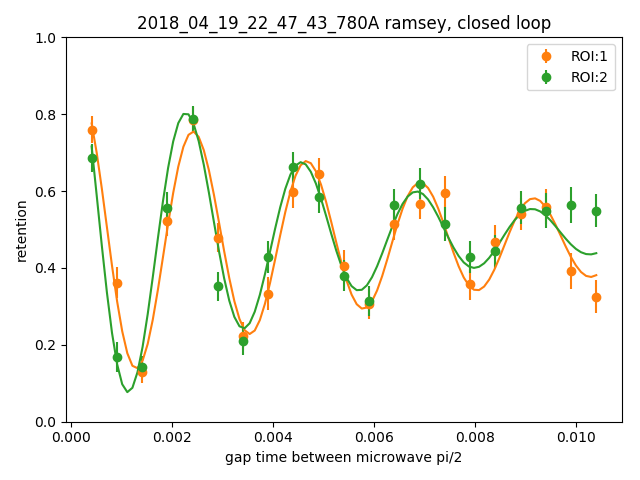

tau 1  is  0.00714776669659  with 1 std of   0.0012168831746
amplitude 1  is  0.398497912809  with 1 std of   0.038511995438
frequency 1  is  444.30631461  with 1 std of   4.00062945593
phase 1  is  1.08144904487  with 1 std of   0.101406618761
offset 1  is  0.470915888079  with 1 std of   0.00954204367892
tau 2  is  0.00441340211202  with 1 std of   0.000793107173868
amplitude 2  is  0.530501559983  with 1 std of   0.0687232541592
frequency 2  is  437.278387749  with 1 std of   6.06539511587
phase 2  is  1.54990828909  with 1 std of   0.111446418505
offset 2  is  0.486776992709  with 1 std of   0.0127744437916
2018_04_19_23_20_45_780A ramsey, closed loop
14


<IPython.core.display.Javascript object>


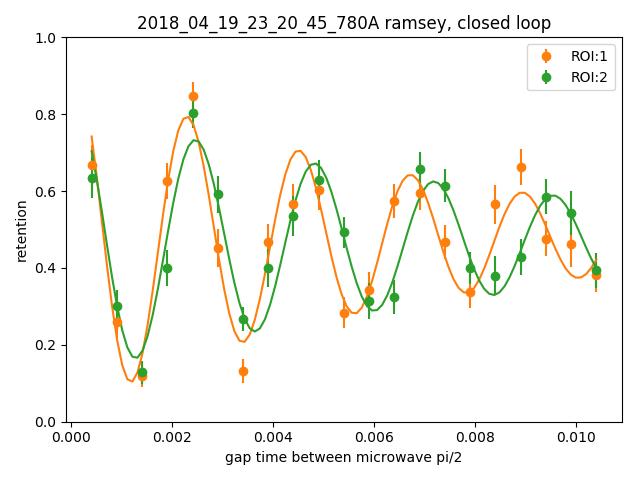

tau 1  is  0.00684926631075  with 1 std of   0.00158401338019
amplitude 1  is  0.444075138402  with 1 std of   0.0598625605314
frequency 1  is  451.351135515  with 1 std of   5.18804376913
phase 1  is  1.3205539952  with 1 std of   0.128084155118
offset 1  is  0.47642985749  with 1 std of   0.0139186260486
tau 2  is  0.00904146139452  with 1 std of   0.00247741983264
amplitude 2  is  0.348764445662  with 1 std of   0.0470705103003
frequency 2  is  423.080416066  with 1 std of   4.63755787003
phase 2  is  1.29335544106  with 1 std of   0.130296728835
offset 2  is  0.46774696808  with 1 std of   0.0119992952297
2018_04_19_23_50_26_780A ramsey, closed loop
15


<IPython.core.display.Javascript object>


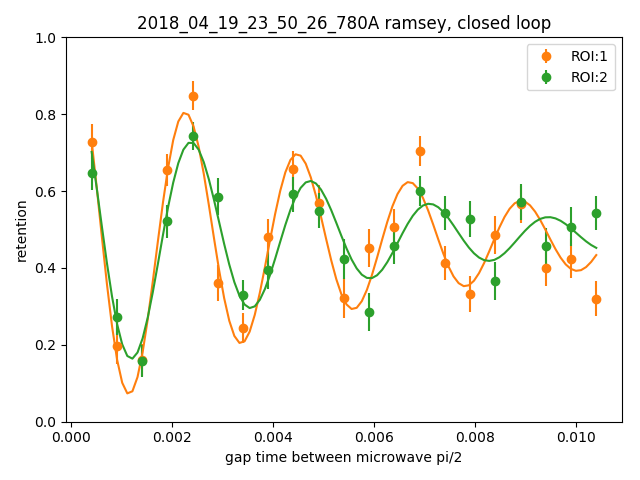

tau 1  is  0.00558997773255  with 1 std of   0.00112877485052
amplitude 1  is  0.494868237023  with 1 std of   0.0647107880144
frequency 1  is  450.40350007  with 1 std of   5.425593937
phase 1  is  1.42141930625  with 1 std of   0.118907830631
offset 1  is  0.474624845055  with 1 std of   0.0136798800795
tau 2  is  0.00443115784524  with 1 std of   0.00104321683622
amplitude 2  is  0.418895776906  with 1 std of   0.0701482599928
frequency 2  is  423.526301844  with 1 std of   7.92716126566
phase 2  is  1.46820990414  with 1 std of   0.148777618829
offset 2  is  0.482903486094  with 1 std of   0.0132439332812
2018_04_20_00_18_45_780A ramsey, closed loop
16


<IPython.core.display.Javascript object>

tau 1  is  0.0101025894656  with 1 std of   0.00248759262229
amplitude 1  is  0.37590726304  with 1 std of   0.0424969663323
frequency 1  is  452.417045862  with 1 std of   3.65256547384
phase 1  is  1.39316827135  with 1 std of   0.105541172269
offset 1  is  0.447908862744  with 1 std of   0.0109551891239
tau 2  is  0.0055481705562  with 1 std of   0.00155824773737
amplitude 2  is  0.398628209617  with 1 std of   0.0726649543088
frequency 2  is  410.228490137  with 1 std of   7.32619717935
phase 2  is  1.52255397018  with 1 std of   0.160427958263
offset 2  is  0.494552909778  with 1 std of   0.0150689822926
2018_04_20_00_44_51_780A ramsey, closed loop
17


<IPython.core.display.Javascript object>

tau 1  is  0.0125645185124  with 1 std of   0.00356431088796
amplitude 1  is  0.355475233206  with 1 std of   0.0388561796851
frequency 1  is  463.177722328  with 1 std of   3.42353600536
phase 1  is  1.18239273923  with 1 std of   0.107430532246
offset 1  is  0.446568480168  with 1 std of   0.0108054526481
tau 2  is  0.00694745661257  with 1 std of   0.00191789304164
amplitude 2  is  0.411879397856  with 1 std of   0.0662059637534
frequency 2  is  403.792305888  with 1 std of   5.80105315838
phase 2  is  1.54237484052  with 1 std of   0.143188260719
offset 2  is  0.465529294227  with 1 std of   0.0150004098773
2018_04_20_08_32_02_780A ramsey, closed loop
18


<IPython.core.display.Javascript object>

tau 1  is  0.00757939312479  with 1 std of   0.00117307586366
amplitude 1  is  0.403348702426  with 1 std of   0.033830328492
frequency 1  is  477.029799525  with 1 std of   3.36561241214
phase 1  is  1.00241660233  with 1 std of   0.0886490326571
offset 1  is  0.442877536328  with 1 std of   0.00862159681342
tau 2  is  0.00419385323899  with 1 std of   0.000843025973793
amplitude 2  is  0.504413620815  with 1 std of   0.0740473340034
frequency 2  is  409.304359389  with 1 std of   6.74441565331
phase 2  is  1.66702820794  with 1 std of   0.119559689373
offset 2  is  0.465184682225  with 1 std of   0.0130857993639
2018_04_20_09_20_41_780A ramsey, closed loop
19


<IPython.core.display.Javascript object>


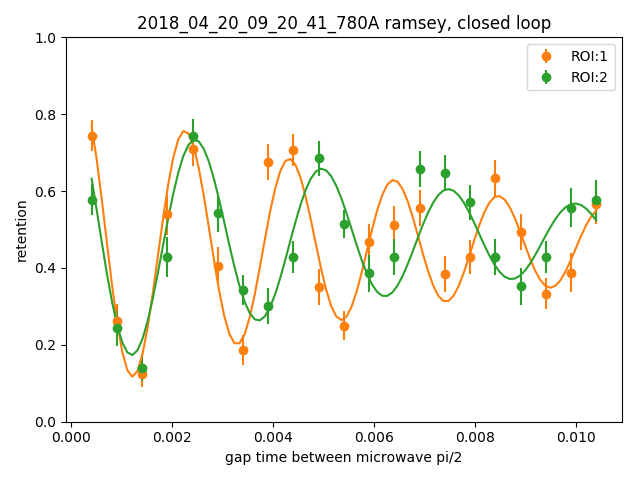

tau 1  is  0.00735040830427  with 1 std of   0.00190651449343
amplitude 1  is  0.40433944817  with 1 std of   0.0583231699662
frequency 1  is  483.160990056  with 1 std of   5.97995939175
phase 1  is  0.992146583717  with 1 std of   0.154087900618
offset 1  is  0.459648858071  with 1 std of   0.0147835741132
tau 2  is  0.0071934091791  with 1 std of   0.00229650020782
amplitude 2  is  0.360128834211  with 1 std of   0.0663807242156
frequency 2  is  398.446184956  with 1 std of   6.4495620987
phase 2  is  1.66986190266  with 1 std of   0.159616685752
offset 2  is  0.477905459383  with 1 std of   0.0150515737065
2018_04_20_10_49_28_780A ramsey, closed loop
20


C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

tau 1  is  0.00748560704973  with 1 std of   0.00161472979617
amplitude 1  is  0.451838085691  with 1 std of   0.0537845904366
frequency 1  is  461.314767524  with 1 std of   4.28734419323
phase 1  is  1.34995222375  with 1 std of   0.111053536012
offset 1  is  0.461807234064  with 1 std of   0.0127945866444
tau 2  is  0.0077716737899  with 1 std of   0.00236448508548
amplitude 2  is  0.349912828332  with 1 std of   0.0591786879017
frequency 2  is  391.013997596  with 1 std of   6.21623875776
phase 2  is  1.48361880271  with 1 std of   0.15902608123
offset 2  is  0.483726437573  with 1 std of   0.0143180479193
2018_04_20_11_47_15_780A ramsey, closed loop
21


<IPython.core.display.Javascript object>


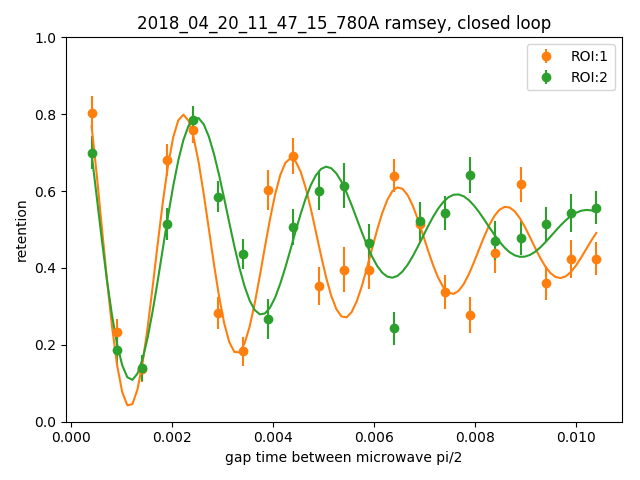

tau 1  is  0.00530057782968  with 1 std of   0.00122061820794
amplitude 1  is  0.519955207134  with 1 std of   0.0782959985862
frequency 1  is  468.798823747  with 1 std of   6.69847283827
phase 1  is  1.26261188122  with 1 std of   0.144315239997
offset 1  is  0.457216117297  with 1 std of   0.0166710711017
tau 2  is  0.00449776108231  with 1 std of   0.000798360109693
amplitude 2  is  0.510121165416  with 1 std of   0.0655735007761
frequency 2  is  387.694140975  with 1 std of   5.77030015497
phase 2  is  1.73050116293  with 1 std of   0.106005601125
offset 2  is  0.498552423789  with 1 std of   0.0121209976341
2018_04_20_12_26_31_780A ramsey, closed loop
22


<IPython.core.display.Javascript object>


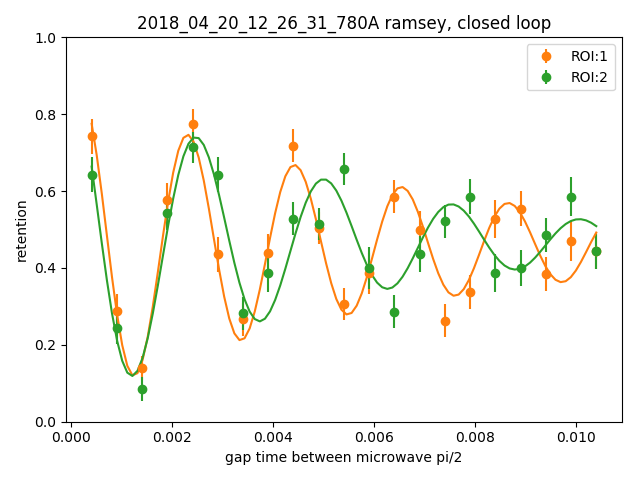

tau 1  is  0.00666547889687  with 1 std of   0.0011444093843
amplitude 1  is  0.408454210802  with 1 std of   0.0403009321534
frequency 1  is  471.955510024  with 1 std of   4.17937937566
phase 1  is  0.986262788243  with 1 std of   0.104710857893
offset 1  is  0.457942098652  with 1 std of   0.00986704613827
tau 2  is  0.00488274408285  with 1 std of   0.00119624101232
amplitude 2  is  0.449957378064  with 1 std of   0.076885547248
frequency 2  is  394.774012586  with 1 std of   7.34777266443
phase 2  is  1.66305254814  with 1 std of   0.144457237003
offset 2  is  0.46990202333  with 1 std of   0.0148837081202
2018_04_20_13_07_25_780A ramsey, closed loop
23


<IPython.core.display.Javascript object>


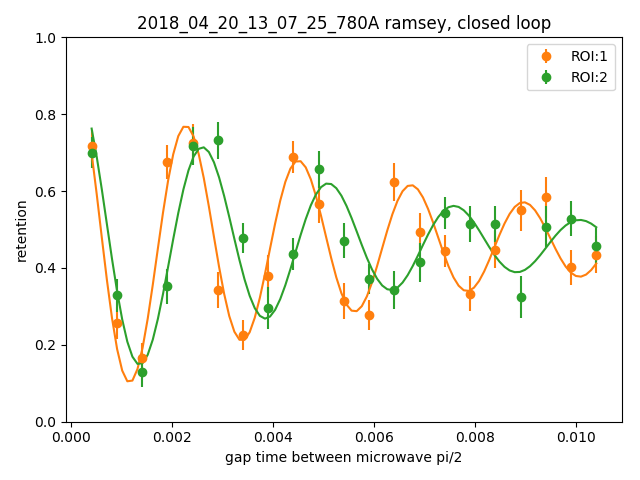

tau 1  is  0.00631263825964  with 1 std of   0.00126063960354
amplitude 1  is  0.436613180136  with 1 std of   0.0534303253888
frequency 1  is  448.473166352  with 1 std of   4.80234038523
phase 1  is  1.41207206779  with 1 std of   0.112646931353
offset 1  is  0.465637510112  with 1 std of   0.0118944923459
tau 2  is  0.0052528311242  with 1 std of   0.00120550835138
amplitude 2  is  0.409995636226  with 1 std of   0.0616342351708
frequency 2  is  401.447884731  with 1 std of   7.09279037991
phase 2  is  1.23237997043  with 1 std of   0.15278013721
offset 2  is  0.464941028774  with 1 std of   0.0133840491318
2018_04_20_13_49_08_780A ramsey, closed loop
24


<IPython.core.display.Javascript object>

tau 1  is  0.00499283607339  with 1 std of   0.000641681034419
amplitude 1  is  0.531689038052  with 1 std of   0.0463469996993
frequency 1  is  449.550378471  with 1 std of   3.890105814
phase 1  is  1.40341330566  with 1 std of   0.0794439211323
offset 1  is  0.476639178427  with 1 std of   0.0093526819658
tau 2  is  0.00712517372565  with 1 std of   0.00193466798327
amplitude 2  is  0.374066399189  with 1 std of   0.0601060816524
frequency 2  is  383.663764647  with 1 std of   5.77008045375
phase 2  is  1.75763115674  with 1 std of   0.139264592329
offset 2  is  0.446584418067  with 1 std of   0.0136788123118
2018_04_20_14_27_42_780A ramsey, closed loop
25


<IPython.core.display.Javascript object>


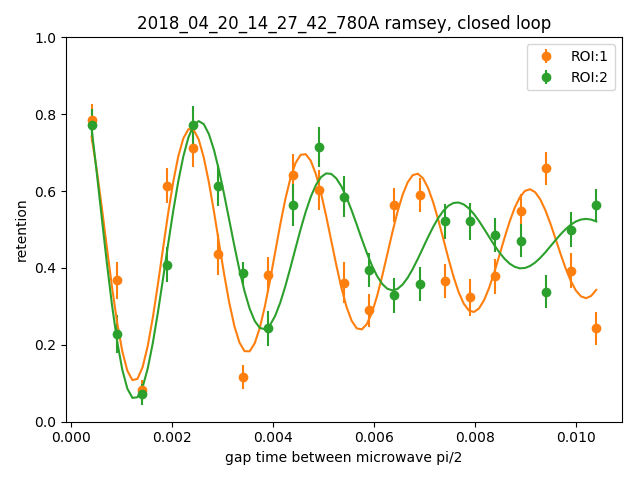

tau 1  is  0.0093095923621  with 1 std of   0.00281567976803
amplitude 1  is  0.398619885281  with 1 std of   0.0586884576019
frequency 1  is  447.130735445  with 1 std of   5.3082607294
phase 1  is  1.17279808148  with 1 std of   0.148914274959
offset 1  is  0.454628532462  with 1 std of   0.0154058556477
tau 2  is  0.00444508875107  with 1 std of   0.000807158296219
amplitude 2  is  0.549443186185  with 1 std of   0.0716266904941
frequency 2  is  391.355498426  with 1 std of   6.20784420946
phase 2  is  1.54272116918  with 1 std of   0.115480465741
offset 2  is  0.47246645647  with 1 std of   0.0135505180099
2018_04_20_14_51_43_780A ramsey, closed loop
26


<IPython.core.display.Javascript object>


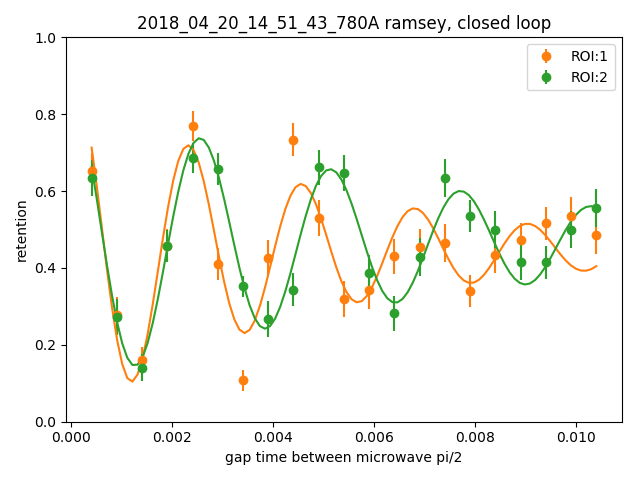

tau 1  is  0.00486569697741  with 1 std of   0.00135827988208
amplitude 1  is  0.439135014299  with 1 std of   0.08356907338
frequency 1  is  446.170500069  with 1 std of   8.99390034019
phase 1  is  1.30210393537  with 1 std of   0.181880428155
offset 1  is  0.446898491356  with 1 std of   0.01704285406
tau 2  is  0.00725815904431  with 1 std of   0.00126246836881
amplitude 2  is  0.383844344574  with 1 std of   0.0388546348378
frequency 2  is  387.490553392  with 1 std of   3.72033949887
phase 2  is  1.6028275565  with 1 std of   0.0914892322231
offset 2  is  0.467943616626  with 1 std of   0.00904966640774
2018_04_20_15_21_04_780A ramsey, closed loop
27


<IPython.core.display.Javascript object>


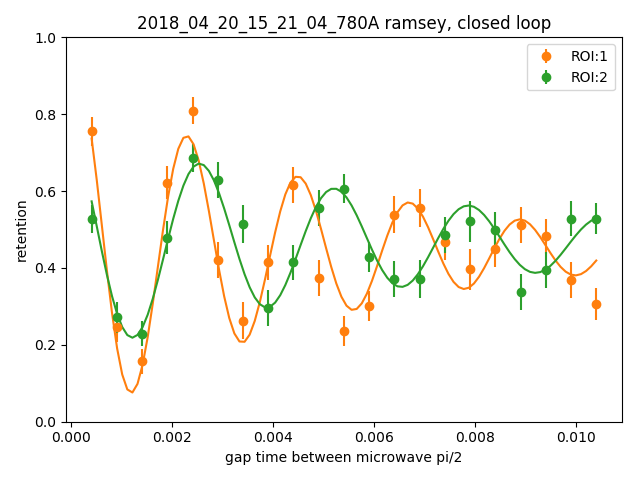

tau 1  is  0.00505753681342  with 1 std of   0.00111119989648
amplitude 1  is  0.469381245228  with 1 std of   0.0686050841142
frequency 1  is  454.475227489  with 1 std of   6.72028073177
phase 1  is  1.26412292641  with 1 std of   0.14069587741
offset 1  is  0.445683231683  with 1 std of   0.0142927786899
tau 2  is  0.007007438962  with 1 std of   0.00173290503592
amplitude 2  is  0.295146660196  with 1 std of   0.0434303548431
frequency 2  is  375.588676451  with 1 std of   5.23222120398
phase 2  is  1.8049406015  with 1 std of   0.125700286833
offset 2  is  0.46658655677  with 1 std of   0.00977256172762
2018_04_20_15_44_45_780A ramsey, closed loop
28


<IPython.core.display.Javascript object>


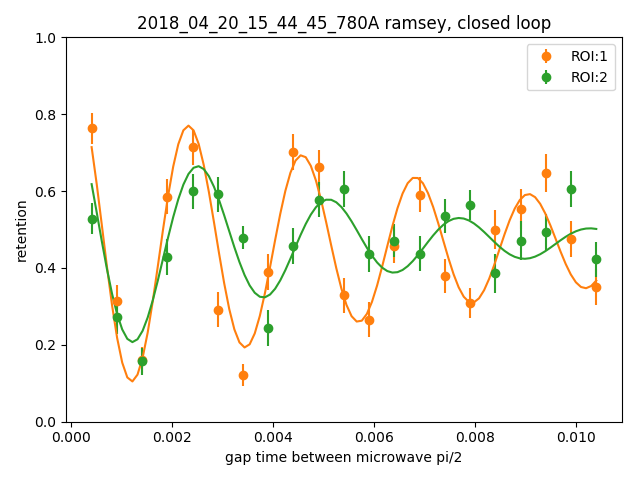

tau 1  is  0.00787649966504  with 1 std of   0.00239364139927
amplitude 1  is  0.415418026273  with 1 std of   0.0687667658023
frequency 1  is  445.0048281  with 1 std of   6.10234451836
phase 1  is  1.32696298783  with 1 std of   0.159103438335
offset 1  is  0.461118263117  with 1 std of   0.016804019772
tau 2  is  0.00442855221032  with 1 std of   0.0014817745531
amplitude 2  is  0.346060622921  with 1 std of   0.0841049452838
frequency 2  is  386.273797001  with 1 std of   11.1744958446
phase 2  is  1.68075350195  with 1 std of   0.20397251745
offset 2  is  0.469241891255  with 1 std of   0.0155466642473
2018_04_20_16_05_33_780A ramsey, closed loop
29


<IPython.core.display.Javascript object>


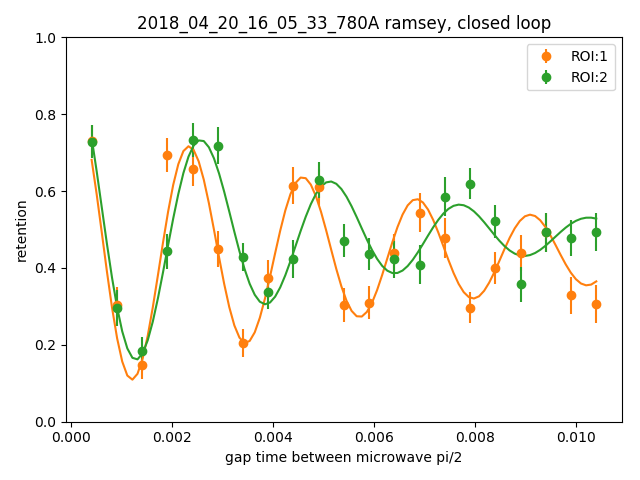

tau 1  is  0.00660864681404  with 1 std of   0.00162500916799
amplitude 1  is  0.395656229817  with 1 std of   0.0583775689917
frequency 1  is  443.450072011  with 1 std of   5.90222943284
phase 1  is  1.31840092885  with 1 std of   0.14187994207
offset 1  is  0.43886511427  with 1 std of   0.013484546906
tau 2  is  0.00441069391475  with 1 std of   0.000844011923949
amplitude 2  is  0.438909456302  with 1 std of   0.0602245633556
frequency 2  is  390.01673936  with 1 std of   6.71140546693
phase 2  is  1.48704306751  with 1 std of   0.124951936765
offset 2  is  0.488381688589  with 1 std of   0.0114958535189
2018_04_20_16_23_49_780A ramsey, closed loop
30


<IPython.core.display.Javascript object>


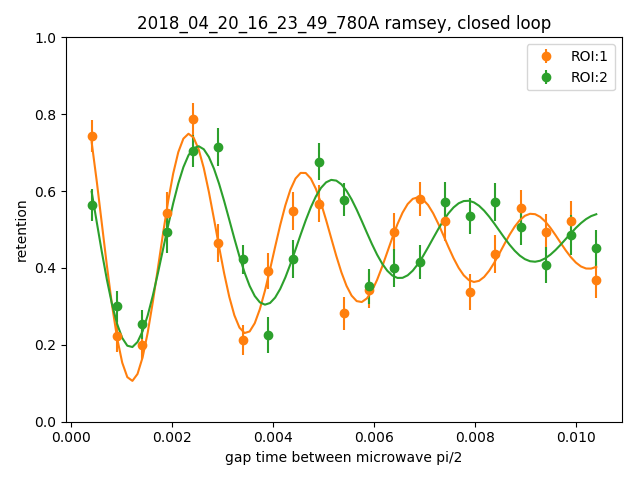

tau 1  is  0.00528385182862  with 1 std of   0.000855012946004
amplitude 1  is  0.447131707395  with 1 std of   0.048110911667
frequency 1  is  441.47430943  with 1 std of   4.82009871349
phase 1  is  1.33663855547  with 1 std of   0.102124504511
offset 1  is  0.46190265681  with 1 std of   0.010139139881
tau 2  is  0.00559141304134  with 1 std of   0.00158361641817
amplitude 2  is  0.362296703399  with 1 std of   0.0684630999345
frequency 2  is  375.328616771  with 1 std of   7.37087455224
phase 2  is  1.8590498791  with 1 std of   0.155675393047
offset 2  is  0.486233463169  with 1 std of   0.0139603515959
2018_04_20_16_40_40_780A ramsey, closed loop
31


<IPython.core.display.Javascript object>


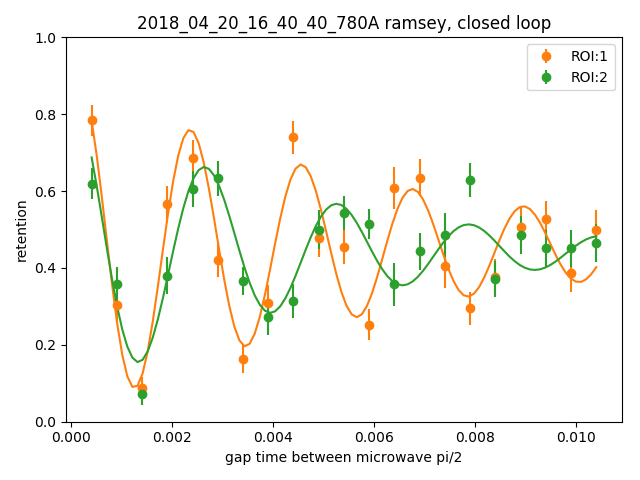

tau 1  is  0.00629255827655  with 1 std of   0.00160700765054
amplitude 1  is  0.445989452306  with 1 std of   0.0681303103774
frequency 1  is  454.203115488  with 1 std of   6.55795457696
phase 1  is  1.09291418691  with 1 std of   0.157779569706
offset 1  is  0.453265024246  with 1 std of   0.0160350566317
tau 2  is  0.00450027364451  with 1 std of   0.00114587140588
amplitude 2  is  0.391713773712  with 1 std of   0.0705938874324
frequency 2  is  381.936794849  with 1 std of   8.86087190519
phase 2  is  1.44075963337  with 1 std of   0.168843896956
offset 2  is  0.445589308327  with 1 std of   0.013817612849
2018_04_20_17_23_53_780A ramsey, closed loop
32


<IPython.core.display.Javascript object>


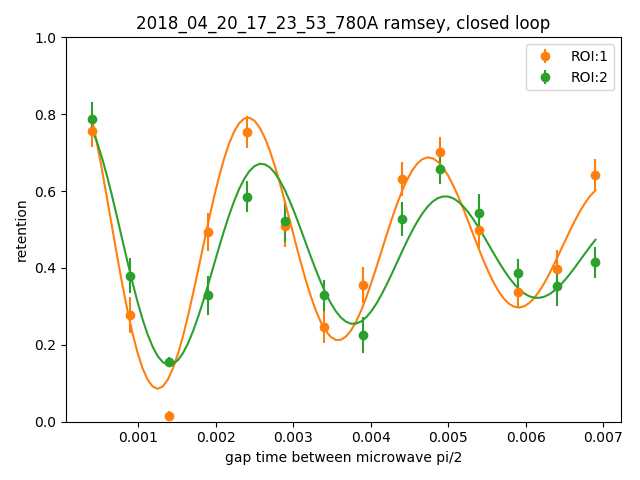

tau 1  is  0.00590839055029  with 1 std of   0.00149557823656
amplitude 1  is  0.479814414004  with 1 std of   0.0628359471285
frequency 1  is  429.46221278  with 1 std of   7.07063825669
phase 1  is  1.27248636639  with 1 std of   0.131639549857
offset 1  is  0.473155667729  with 1 std of   0.0159267540258
tau 2  is  0.00521482510454  with 1 std of   0.00164884216112
amplitude 2  is  0.382389279515  with 1 std of   0.0633143774973
frequency 2  is  421.274285561  with 1 std of   10.2379145358
phase 2  is  0.928773162227  with 1 std of   0.19243363245
offset 2  is  0.439233502146  with 1 std of   0.0166778161198
2018_04_20_18_10_59_780A ramsey, closed loop
33


<IPython.core.display.Javascript object>


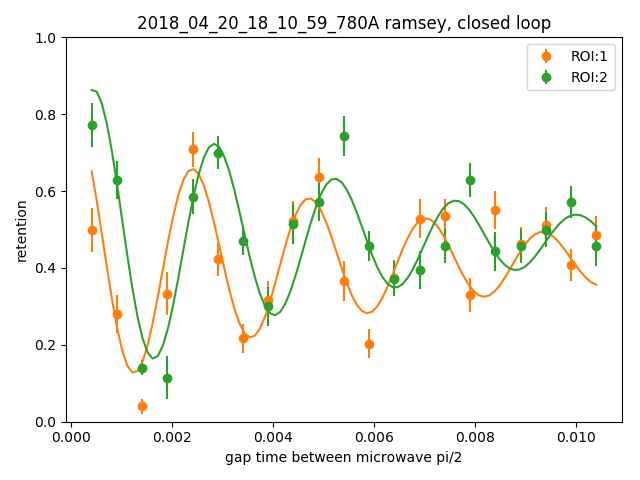

tau 1  is  0.00605406066451  with 1 std of   0.00245233950513
amplitude 1  is  0.357435365564  with 1 std of   0.0903404155278
frequency 1  is  432.384461282  with 1 std of   10.6656522326
phase 1  is  1.28184343636  with 1 std of   0.246525153653
offset 1  is  0.417503915477  with 1 std of   0.0203815532641
tau 2  is  0.00529436683785  with 1 std of   0.00143523568759
amplitude 2  is  0.424124920206  with 1 std of   0.0707253096553
frequency 2  is  418.107553646  with 1 std of   9.20315995611
phase 2  is  0.35658823892  with 1 std of   0.208159662005
offset 2  is  0.474858219166  with 1 std of   0.0172941176513
2018_04_20_19_40_13_780A ramsey, closed loop
34


<IPython.core.display.Javascript object>


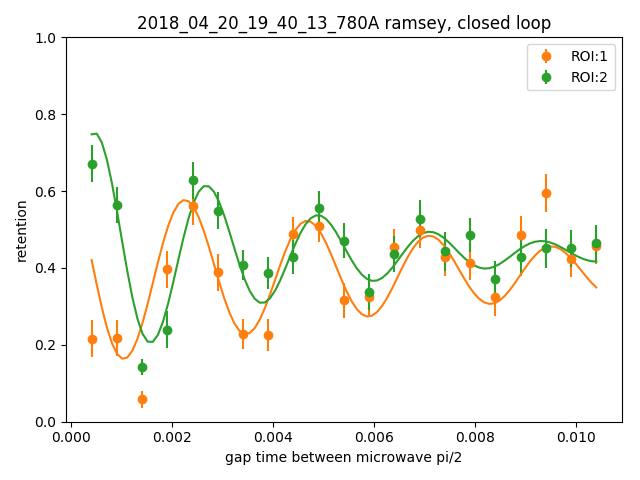

tau 1  is  0.0071516358741  with 1 std of   0.0047673478676
amplitude 1  is  0.259712754421  with 1 std of   0.100802767064
frequency 1  is  413.005760553  with 1 std of   13.0139707878
phase 1  is  1.96893147145  with 1 std of   0.318913549518
offset 1  is  0.387654155045  with 1 std of   0.0222819716622
tau 2  is  0.00381521639432  with 1 std of   0.000870532212732
amplitude 2  is  0.353744196222  with 1 std of   0.0544458802355
frequency 2  is  451.892014872  with 1 std of   10.9210278033
phase 2  is  0.179896801973  with 1 std of   0.197865839902
offset 2  is  0.439435050467  with 1 std of   0.0115858330891
2018_04_20_20_20_52_780A ramsey, closed loop
35


<IPython.core.display.Javascript object>


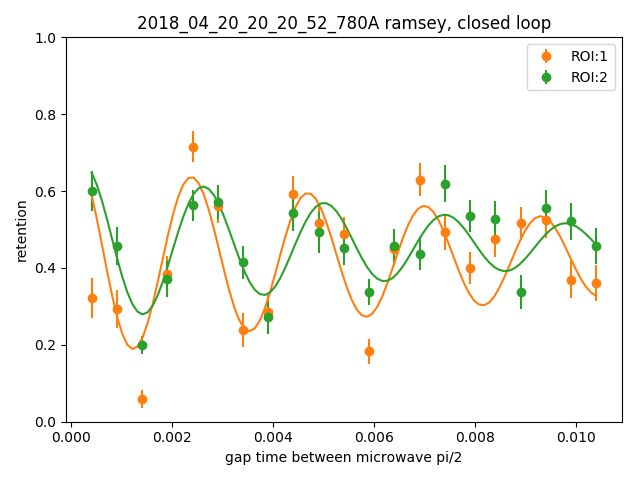

tau 1  is  0.0105487325655  with 1 std of   0.00787618230405
amplitude 1  is  0.265264267747  with 1 std of   0.0900895658829
frequency 1  is  433.139979384  with 1 std of   11.3627686484
phase 1  is  1.35390249955  with 1 std of   0.327884576374
offset 1  is  0.425116769273  with 1 std of   0.02387323048
tau 2  is  0.00731826273965  with 1 std of   0.00379416470049
amplitude 2  is  0.218535425577  with 1 std of   0.0613194450793
frequency 2  is  417.90916685  with 1 std of   11.5171035146
phase 2  is  0.942692420227  with 1 std of   0.305422053559
offset 2  is  0.459119501617  with 1 std of   0.0156102883704
2018_04_21_15_47_33_780A ramsey, closed loop
36


<IPython.core.display.Javascript object>


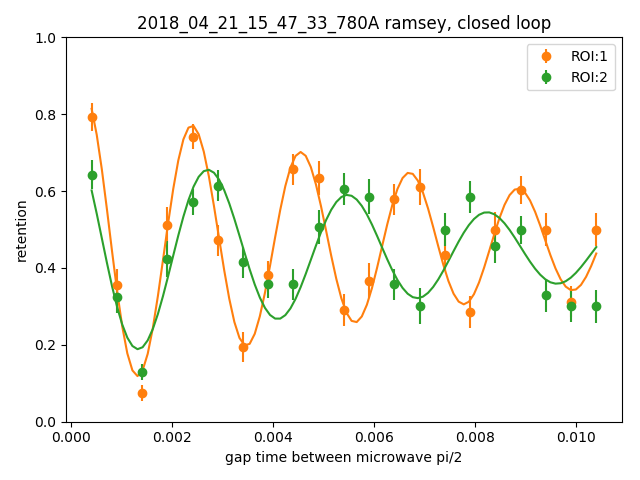

tau 1  is  0.00837745058846  with 1 std of   0.00117670759842
amplitude 1  is  0.406137057071  with 1 std of   0.0285237106752
frequency 1  is  463.944254383  with 1 std of   2.73821237893
phase 1  is  0.857000656482  with 1 std of   0.0765593658349
offset 1  is  0.465761860453  with 1 std of   0.00759714729238
tau 2  is  0.00751170527677  with 1 std of   0.00301162008279
amplitude 2  is  0.30445495707  with 1 std of   0.0680932669735
frequency 2  is  361.50443636  with 1 std of   7.66151707052
phase 2  is  1.65327254646  with 1 std of   0.196193363413
offset 2  is  0.443508854692  with 1 std of   0.0157659268708
2018_04_21_18_53_41_780A ramsey, closed loop
37


<IPython.core.display.Javascript object>


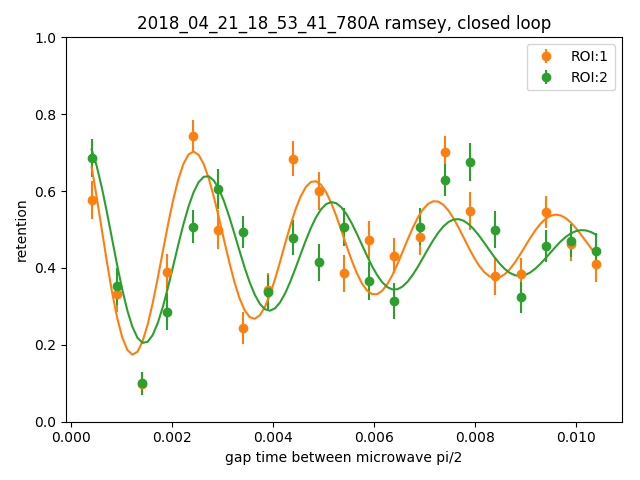

tau 1  is  0.0061753594483  with 1 std of   0.00260774623196
amplitude 1  is  0.353894361495  with 1 std of   0.0920754101374
frequency 1  is  417.539631389  with 1 std of   10.0695825919
phase 1  is  1.45231109144  with 1 std of   0.235776323447
offset 1  is  0.464206947686  with 1 std of   0.020184593285
tau 2  is  0.00574993962332  with 1 std of   0.00249355057869
amplitude 2  is  0.310372304936  with 1 std of   0.0832461832623
frequency 2  is  403.295326363  with 1 std of   13.0412877475
phase 2  is  0.989941507493  with 1 std of   0.301152224849
offset 2  is  0.44528786582  with 1 std of   0.019772094364
2018_04_21_19_12_49_780A ramsey, closed loop
38


<IPython.core.display.Javascript object>


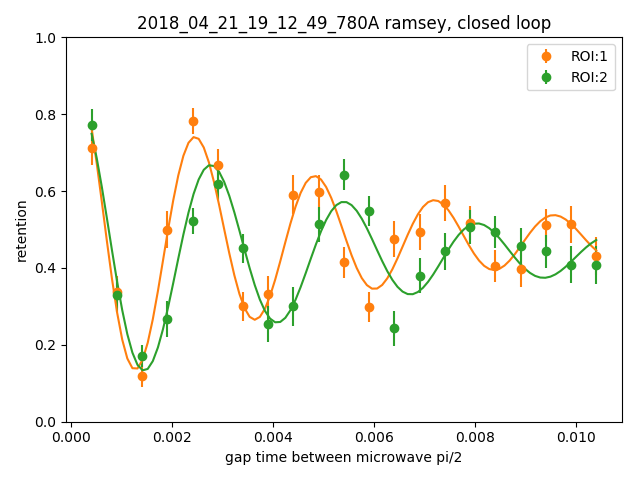

tau 1  is  0.00492787113601  with 1 std of   0.000941260412898
amplitude 1  is  0.439018126709  with 1 std of   0.0563477369596
frequency 1  is  421.809419038  with 1 std of   5.97666565614
phase 1  is  1.29254305321  with 1 std of   0.123629392045
offset 1  is  0.474680179255  with 1 std of   0.0116022943288
tau 2  is  0.00496789268105  with 1 std of   0.00102130630872
amplitude 2  is  0.406096011764  with 1 std of   0.0553139828642
frequency 2  is  378.915649088  with 1 std of   6.79802611939
phase 2  is  1.20019109128  with 1 std of   0.142973768551
offset 2  is  0.435815613215  with 1 std of   0.0120013792041
2018_04_21_19_33_26_780A ramsey, closed loop
39


<IPython.core.display.Javascript object>


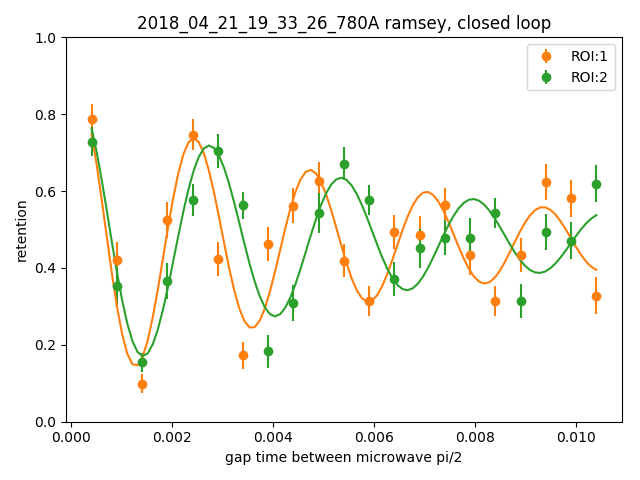

tau 1  is  0.00634773777094  with 1 std of   0.0020772501486
amplitude 1  is  0.395023192742  with 1 std of   0.0783659361437
frequency 1  is  433.544823668  with 1 std of   8.3771620241
phase 1  is  1.19775194621  with 1 std of   0.199903272203
offset 1  is  0.467997995241  with 1 std of   0.0182823381247
tau 2  is  0.00624328873748  with 1 std of   0.00178075908179
amplitude 2  is  0.380849311848  with 1 std of   0.0660744368987
frequency 2  is  382.529925084  with 1 std of   7.52900293701
phase 2  is  1.23249538725  with 1 std of   0.178889686495
offset 2  is  0.473177802786  with 1 std of   0.0155889582945
2018_04_21_19_55_13_780A ramsey, closed loop
40


<IPython.core.display.Javascript object>


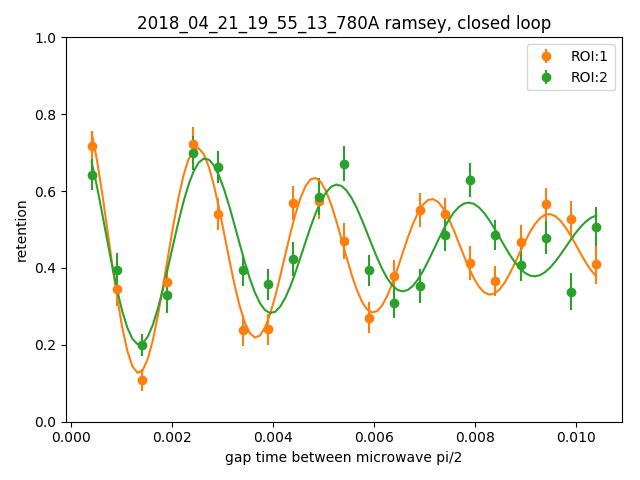

tau 1  is  0.00679043454445  with 1 std of   0.000956354387941
amplitude 1  is  0.387227708472  with 1 std of   0.0314082633544
frequency 1  is  430.553756445  with 1 std of   3.40855145472
phase 1  is  1.05644216913  with 1 std of   0.0855950964589
offset 1  is  0.444349867855  with 1 std of   0.00768453141084
tau 2  is  0.00704365890407  with 1 std of   0.00225170076279
amplitude 2  is  0.320860965354  with 1 std of   0.0598375727976
frequency 2  is  383.266308659  with 1 std of   7.28129301186
phase 2  is  1.41086534667  with 1 std of   0.179948853823
offset 2  is  0.46525733039  with 1 std of   0.0142468894205
2018_04_21_20_16_19_780A ramsey, closed loop
41


<IPython.core.display.Javascript object>


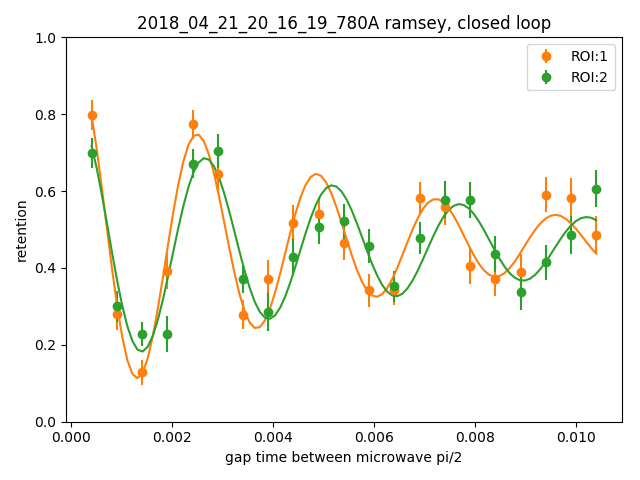

tau 1  is  0.00518088184263  with 1 std of   0.000957847345191
amplitude 1  is  0.455866981361  with 1 std of   0.0549411465745
frequency 1  is  422.293185895  with 1 std of   5.62735016624
phase 1  is  1.18598045897  with 1 std of   0.121593390601
offset 1  is  0.466739556558  with 1 std of   0.0118316444461
tau 2  is  0.00679292431795  with 1 std of   0.00196491519715
amplitude 2  is  0.338177754562  with 1 std of   0.0572831889427
frequency 2  is  396.757869499  with 1 std of   7.14495123241
phase 2  is  1.19419274842  with 1 std of   0.176192230614
offset 2  is  0.457354629852  with 1 std of   0.0139095394416
2018_04_21_20_36_32_780A ramsey, closed loop
42


<IPython.core.display.Javascript object>


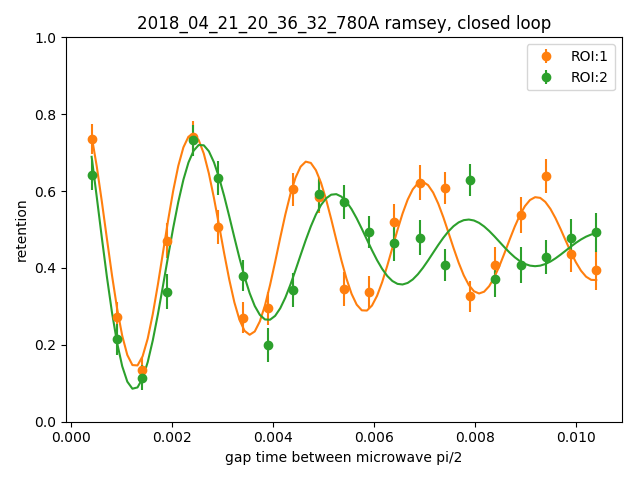

tau 1  is  0.00775263124611  with 1 std of   0.00141900263271
amplitude 1  is  0.382326824518  with 1 std of   0.0383265842398
frequency 1  is  439.897768771  with 1 std of   3.91018277871
phase 1  is  1.17705545664  with 1 std of   0.101941099392
offset 1  is  0.468258496377  with 1 std of   0.00959038641998
tau 2  is  0.00399500422295  with 1 std of   0.000859768697989
amplitude 2  is  0.508747039146  with 1 std of   0.0818330861954
frequency 2  is  377.575846755  with 1 std of   7.91824280496
phase 2  is  1.65968835335  with 1 std of   0.134639516648
offset 2  is  0.455330494398  with 1 std of   0.014339005483
2018_04_21_21_01_09_780A ramsey, closed loop
43


<IPython.core.display.Javascript object>


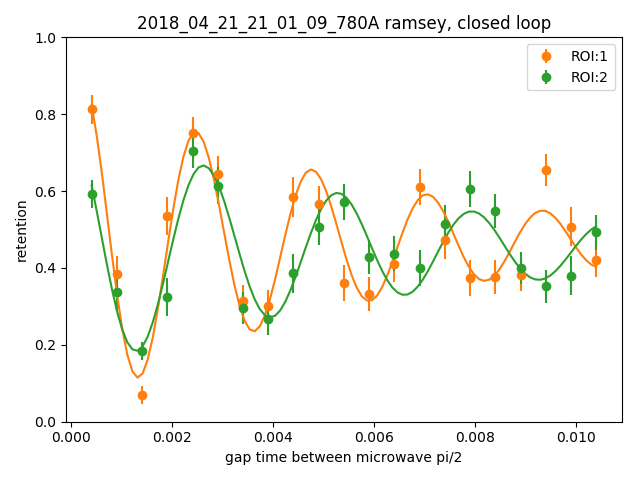

tau 1  is  0.00549369073231  with 1 std of   0.00116028192074
amplitude 1  is  0.449526991049  with 1 std of   0.0603479456226
frequency 1  is  436.728855064  with 1 std of   6.48614611395
phase 1  is  1.02681339945  with 1 std of   0.145036188838
offset 1  is  0.467452890965  with 1 std of   0.0138076190449
tau 2  is  0.00667806604571  with 1 std of   0.00194956401536
amplitude 2  is  0.322086431199  with 1 std of   0.0568033029896
frequency 2  is  376.028845714  with 1 std of   6.59950216331
phase 2  is  1.62102534144  with 1 std of   0.157199467876
offset 2  is  0.44940403346  with 1 std of   0.0128072658283
2018_04_21_21_19_05_780A ramsey, closed loop
44


<IPython.core.display.Javascript object>


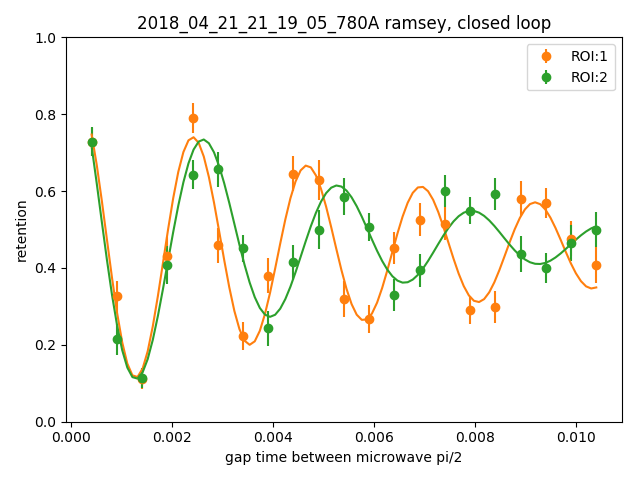

tau 1  is  0.0077146857419  with 1 std of   0.001627979446
amplitude 1  is  0.396347029708  with 1 std of   0.0457293307231
frequency 1  is  442.416075901  with 1 std of   4.57378304323
phase 1  is  1.12208606151  with 1 std of   0.119427548179
offset 1  is  0.450476417499  with 1 std of   0.0115261080004
tau 2  is  0.00442650404009  with 1 std of   0.000715872303031
amplitude 2  is  0.480048655796  with 1 std of   0.0558482599862
frequency 2  is  376.119761908  with 1 std of   5.45848599439
phase 2  is  1.59760833136  with 1 std of   0.101173796879
offset 2  is  0.469221297133  with 1 std of   0.0104865262396
2018_04_21_21_46_30_780A ramsey, closed loop
45


<IPython.core.display.Javascript object>


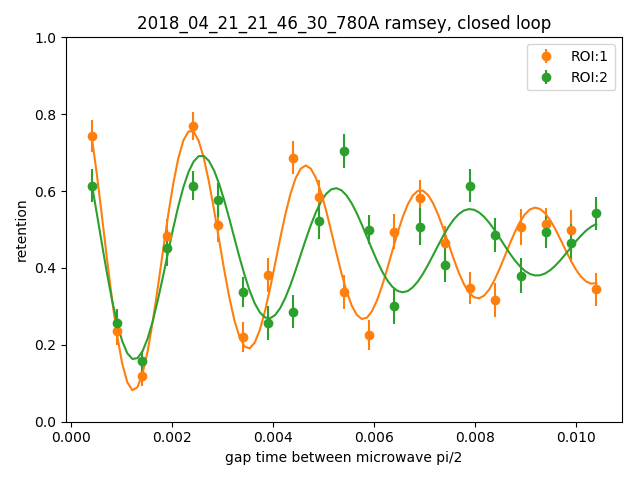

tau 1  is  0.00648632848835  with 1 std of   0.000955357448122
amplitude 1  is  0.445522426857  with 1 std of   0.0396944544682
frequency 1  is  439.531442818  with 1 std of   3.67548182426
phase 1  is  1.26044997184  with 1 std of   0.0877993785122
offset 1  is  0.449264981421  with 1 std of   0.0092226051172
tau 2  is  0.00593349008187  with 1 std of   0.00184095382654
amplitude 2  is  0.364806363654  with 1 std of   0.0729245593094
frequency 2  is  376.007399915  with 1 std of   7.78190712581
phase 2  is  1.69836746896  with 1 std of   0.172496587006
offset 2  is  0.457058643905  with 1 std of   0.0155223371399
2018_04_21_22_12_15_780A ramsey, closed loop
46


<IPython.core.display.Javascript object>


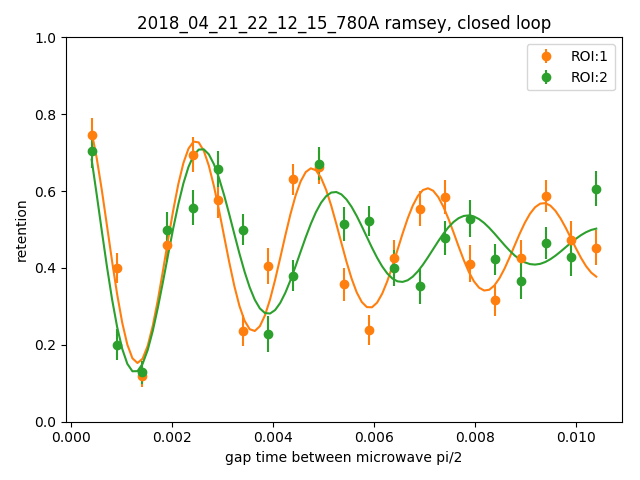

tau 1  is  0.00742628301671  with 1 std of   0.00175529504753
amplitude 1  is  0.371619498305  with 1 std of   0.0487086913548
frequency 1  is  435.026825751  with 1 std of   5.30642813205
phase 1  is  1.08025607204  with 1 std of   0.137488598551
offset 1  is  0.463855108018  with 1 std of   0.0122298098426
tau 2  is  0.00436252684121  with 1 std of   0.00117304630382
amplitude 2  is  0.447854074291  with 1 std of   0.0874195775914
frequency 2  is  378.81975615  with 1 std of   9.19652403559
phase 2  is  1.62457418658  with 1 std of   0.167672309962
offset 2  is  0.463180997488  with 1 std of   0.0162124901914
2018_04_21_22_39_47_780A ramsey, closed loop
47


<IPython.core.display.Javascript object>


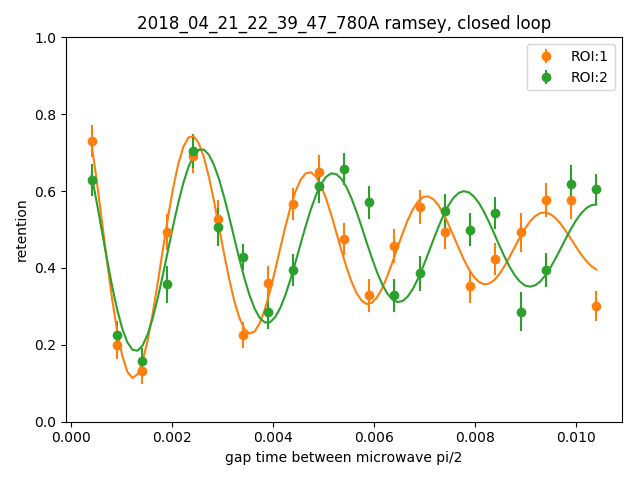

tau 1  is  0.0057544318327  with 1 std of   0.00104326343775
amplitude 1  is  0.429745735776  with 1 std of   0.0499206112668
frequency 1  is  429.66274565  with 1 std of   4.91471303524
phase 1  is  1.3526128126  with 1 std of   0.10996925599
offset 1  is  0.460493725501  with 1 std of   0.010888243966
tau 2  is  0.00868415615941  with 1 std of   0.00332545699573
amplitude 2  is  0.327716379314  with 1 std of   0.0656236541485
frequency 2  is  384.1194048  with 1 std of   6.93195409044
phase 2  is  1.58770282834  with 1 std of   0.184102244663
offset 2  is  0.466318839407  with 1 std of   0.0162763295008
2018_04_21_23_03_01_780A ramsey, closed loop
48


<IPython.core.display.Javascript object>


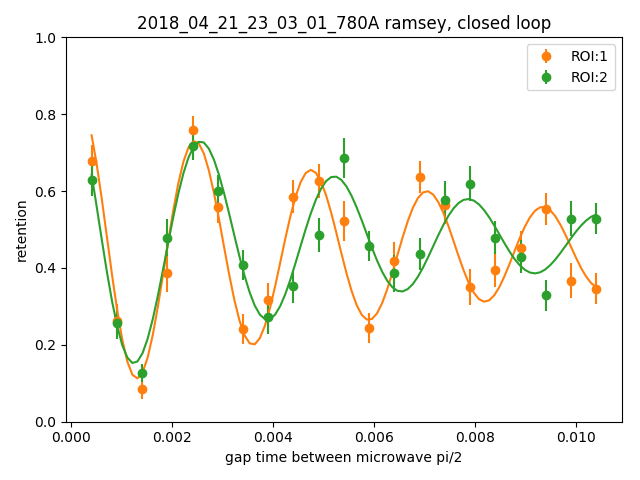

tau 1  is  0.00751361696541  with 1 std of   0.00157539493614
amplitude 1  is  0.395709166284  with 1 std of   0.0459001660979
frequency 1  is  435.039163028  with 1 std of   4.6254391088
phase 1  is  1.12152154728  with 1 std of   0.120016308535
offset 1  is  0.445100599113  with 1 std of   0.0114846191004
tau 2  is  0.00605749374991  with 1 std of   0.00129123336606
amplitude 2  is  0.393396800126  with 1 std of   0.0536383092748
frequency 2  is  377.648659249  with 1 std of   5.26119602886
phase 2  is  1.71123590636  with 1 std of   0.117618368145
offset 2  is  0.472104604445  with 1 std of   0.0115083978955
2018_04_21_23_26_30_780A ramsey, closed loop
49


<IPython.core.display.Javascript object>


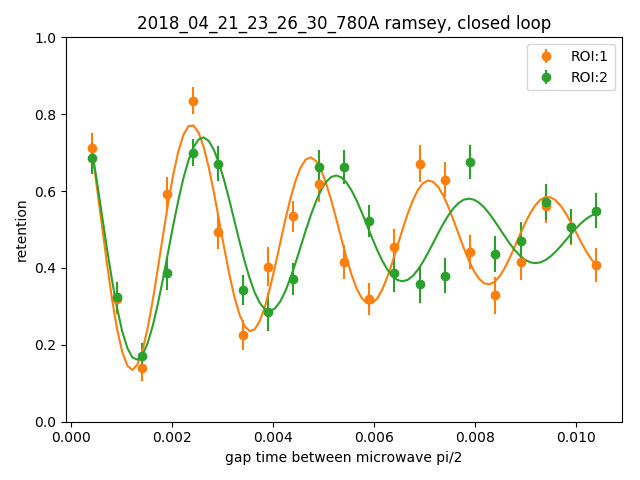

tau 1  is  0.00686326801247  with 1 std of   0.00145814182981
amplitude 1  is  0.412921714312  with 1 std of   0.0517253966985
frequency 1  is  424.99464872  with 1 std of   4.69071556156
phase 1  is  1.45076490641  with 1 std of   0.114878484782
offset 1  is  0.480913211323  with 1 std of   0.0118505007099
tau 2  is  0.0053208133986  with 1 std of   0.00147606760835
amplitude 2  is  0.415300862501  with 1 std of   0.0773911507024
frequency 2  is  379.528554433  with 1 std of   7.97106076101
phase 2  is  1.56073965605  with 1 std of   0.167323038725
offset 2  is  0.486080400545  with 1 std of   0.0160399356142
2018_04_21_23_50_06_780A ramsey, closed loop
50


<IPython.core.display.Javascript object>


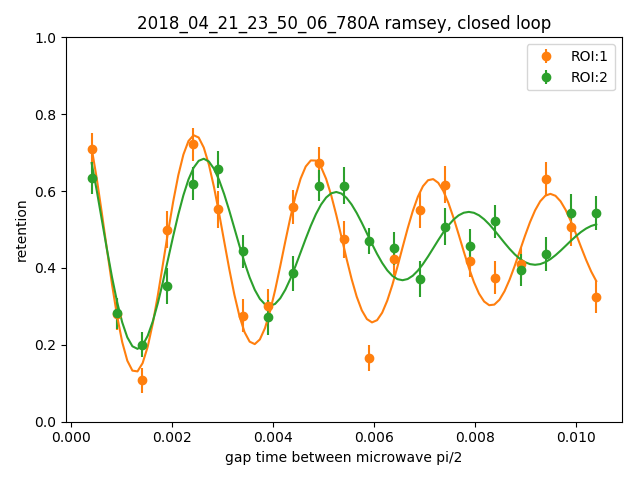

tau 1  is  0.00935267133425  with 1 std of   0.00191050634979
amplitude 1  is  0.375713775563  with 1 std of   0.0371378154577
frequency 1  is  425.669637226  with 1 std of   3.39303851786
phase 1  is  1.28376674009  with 1 std of   0.0960763837817
offset 1  is  0.456705182064  with 1 std of   0.00958641685589
tau 2  is  0.00513587109026  with 1 std of   0.00108319682253
amplitude 2  is  0.360335575087  with 1 std of   0.0516613545034
frequency 2  is  380.392412473  with 1 std of   6.32646911873
phase 2  is  1.52421373664  with 1 std of   0.13034073532
offset 2  is  0.468301398915  with 1 std of   0.0106036844827
2018_04_22_00_15_48_780A ramsey, closed loop
51


<IPython.core.display.Javascript object>


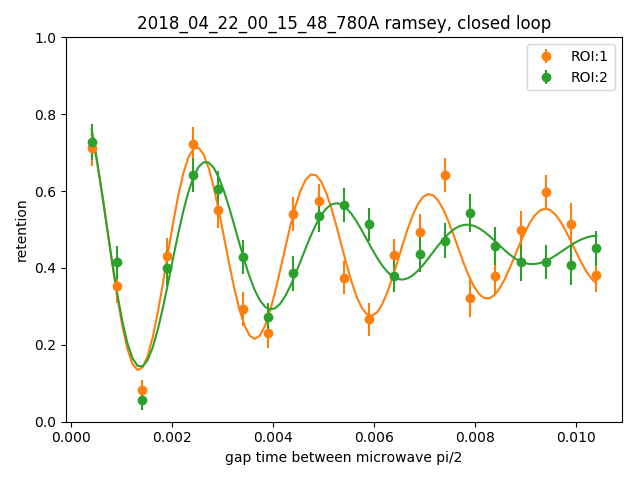

tau 1  is  0.0076136295381  with 1 std of   0.0016936577838
amplitude 1  is  0.372059322483  with 1 std of   0.0450578133619
frequency 1  is  434.135168809  with 1 std of   4.8827900158
phase 1  is  1.04070109872  with 1 std of   0.128451364449
offset 1  is  0.445993264473  with 1 std of   0.011469367581
tau 2  is  0.00393162530718  with 1 std of   0.000607438133787
amplitude 2  is  0.442281224806  with 1 std of   0.0495051695773
frequency 2  is  386.297772547  with 1 std of   6.41510068629
phase 2  is  1.28978606428  with 1 std of   0.113061032338
offset 2  is  0.452925767774  with 1 std of   0.00936428554353
2018_04_22_01_07_55_780A ramsey, closed loop
52


<IPython.core.display.Javascript object>


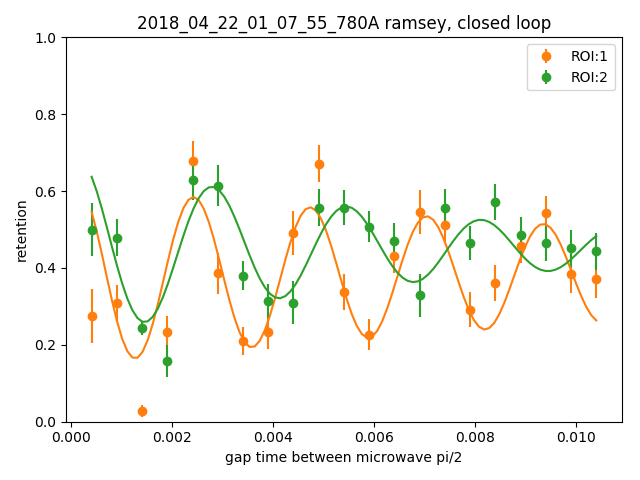

tau 1  is  0.0163431610002  with 1 std of   0.0176523633754
amplitude 1  is  0.234945871981  with 1 std of   0.0822505544761
frequency 1  is  432.741672758  with 1 std of   10.7805145662
phase 1  is  1.259907158  with 1 std of   0.347964038688
offset 1  is  0.382049082661  with 1 std of   0.0240567838525
tau 2  is  0.00686813891584  with 1 std of   0.00407625360018
amplitude 2  is  0.238962950768  with 1 std of   0.0813461794491
frequency 2  is  375.322457593  with 1 std of   13.7904145279
phase 2  is  1.23484002877  with 1 std of   0.347438257911
offset 2  is  0.452156523188  with 1 std of   0.0197511106271
2018_04_22_01_32_59_780A ramsey, closed loop
53


<IPython.core.display.Javascript object>


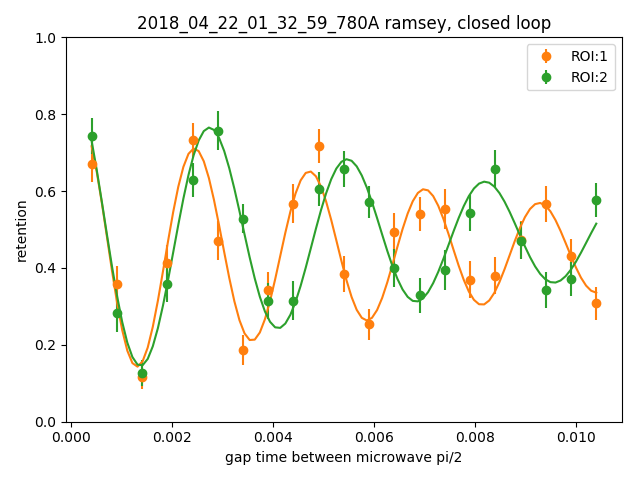

tau 1  is  0.0089747020072  with 1 std of   0.00211141197037
amplitude 1  is  0.349283084066  with 1 std of   0.0409977838368
frequency 1  is  439.030445596  with 1 std of   4.42257658056
phase 1  is  1.09005546146  with 1 std of   0.12269317843
offset 1  is  0.445066044612  with 1 std of   0.0108504005539
tau 2  is  0.00795510492235  with 1 std of   0.00143149069094
amplitude 2  is  0.400239881147  with 1 std of   0.0385350455914
frequency 2  is  366.313992555  with 1 std of   3.33856180338
phase 2  is  1.50922164931  with 1 std of   0.0885740846434
offset 2  is  0.481896911094  with 1 std of   0.00929577842884
2018_04_22_01_56_39_780A ramsey, closed loop
54


<IPython.core.display.Javascript object>


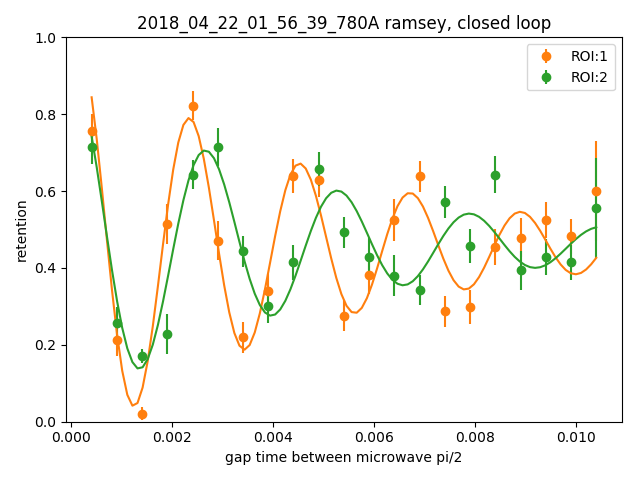

tau 1  is  0.00500651214509  with 1 std of   0.00113879273321
amplitude 1  is  0.533813217304  with 1 std of   0.0796756523927
frequency 1  is  457.13159871  with 1 std of   7.32988624258
phase 1  is  1.08611977327  with 1 std of   0.155108963251
offset 1  is  0.455993874245  with 1 std of   0.0171808869941
tau 2  is  0.00469643189731  with 1 std of   0.00137383352204
amplitude 2  is  0.432412010429  with 1 std of   0.0878684057004
frequency 2  is  382.336170541  with 1 std of   9.88142015895
phase 2  is  1.39543414573  with 1 std of   0.19488978005
offset 2  is  0.461120251795  with 1 std of   0.0177495612353
2018_04_22_12_40_38_780A ramsey, closed loop
55


<IPython.core.display.Javascript object>


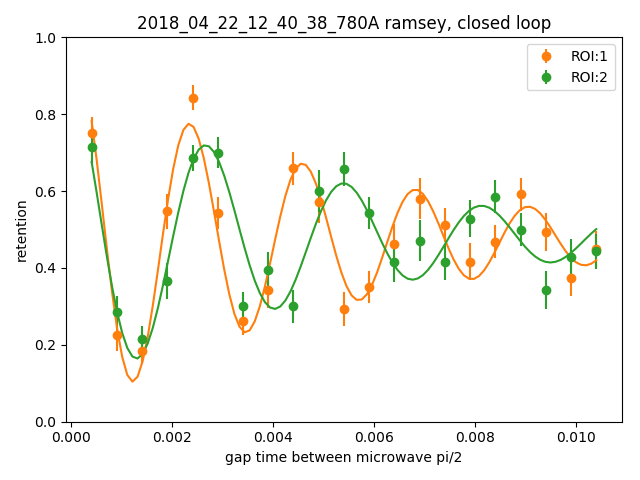

tau 1  is  0.00529692853036  with 1 std of   0.00082521938518
amplitude 1  is  0.467676199699  with 1 std of   0.0478378015313
frequency 1  is  446.62308144  with 1 std of   4.69974102337
phase 1  is  1.23360137267  with 1 std of   0.100909816094
offset 1  is  0.475117750345  with 1 std of   0.0102793889709
tau 2  is  0.00516073458087  with 1 std of   0.00143568194145
amplitude 2  is  0.404848072917  with 1 std of   0.0762311940285
frequency 2  is  365.743460996  with 1 std of   7.78497706814
phase 2  is  1.66708303361  with 1 std of   0.160711461279
offset 2  is  0.478393332681  with 1 std of   0.0152034103842
2018_04_22_13_25_53_780A ramsey, closed loop
56


<IPython.core.display.Javascript object>


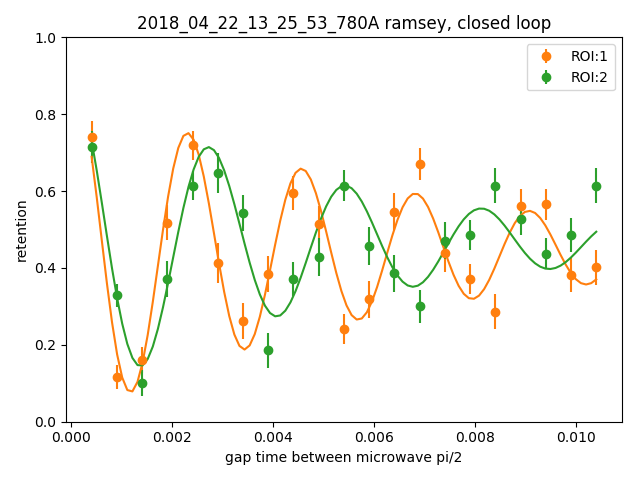

tau 1  is  0.00627738609879  with 1 std of   0.00136137237883
amplitude 1  is  0.443478564258  with 1 std of   0.0594710538233
frequency 1  is  443.074631703  with 1 std of   5.3700043635
phase 1  is  1.39887799372  with 1 std of   0.124973029347
offset 1  is  0.444255675126  with 1 std of   0.0132904821839
tau 2  is  0.00525790516402  with 1 std of   0.00137788128467
amplitude 2  is  0.417844892931  with 1 std of   0.0724813958645
frequency 2  is  370.100666273  with 1 std of   7.56024003344
phase 2  is  1.45975933482  with 1 std of   0.161248972796
offset 2  is  0.465983986368  with 1 std of   0.0151589412516
2018_04_22_14_14_58_780A ramsey, closed loop
57


<IPython.core.display.Javascript object>


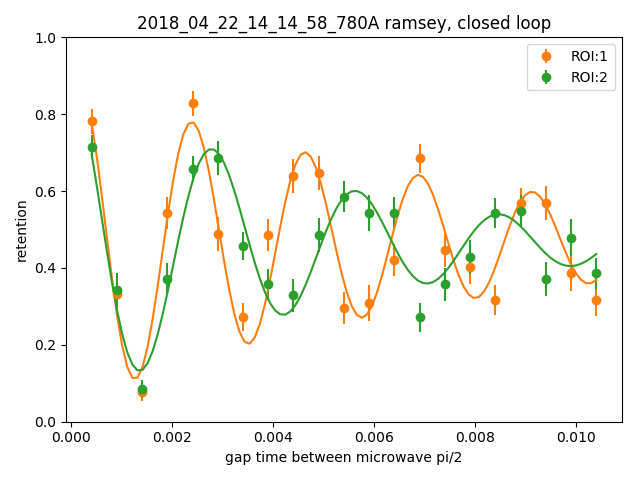

tau 1  is  0.0076387458349  with 1 std of   0.00186321971094
amplitude 1  is  0.424143236222  with 1 std of   0.0568836645369
frequency 1  is  444.847571636  with 1 std of   5.2725450267
phase 1  is  1.15396457082  with 1 std of   0.136986370544
offset 1  is  0.470092695262  with 1 std of   0.0141932401376
tau 2  is  0.00489222972523  with 1 std of   0.0010449602948
amplitude 2  is  0.437255508108  with 1 std of   0.0648514400917
frequency 2  is  351.378824525  with 1 std of   6.45177509314
phase 2  is  1.64106016011  with 1 std of   0.12833373372
offset 2  is  0.462644084207  with 1 std of   0.0126499814512
2018_04_22_14_14_58_780A ramsey, closed loop
58


<IPython.core.display.Javascript object>


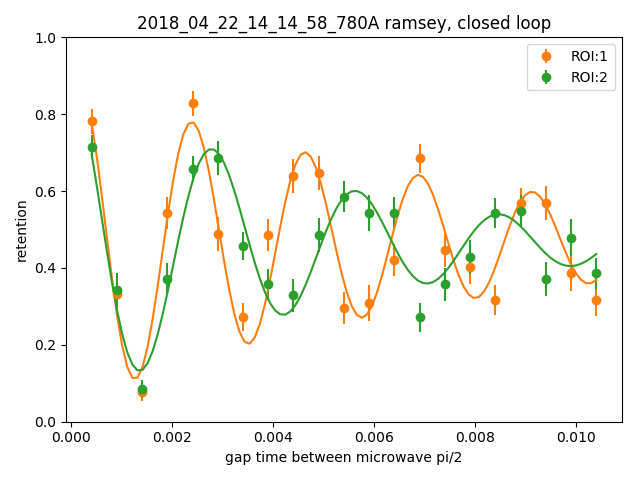

tau 1  is  0.0076387458349  with 1 std of   0.00186321971094
amplitude 1  is  0.424143236222  with 1 std of   0.0568836645369
frequency 1  is  444.847571636  with 1 std of   5.2725450267
phase 1  is  1.15396457082  with 1 std of   0.136986370544
offset 1  is  0.470092695262  with 1 std of   0.0141932401376
tau 2  is  0.00489222972523  with 1 std of   0.0010449602948
amplitude 2  is  0.437255508108  with 1 std of   0.0648514400917
frequency 2  is  351.378824525  with 1 std of   6.45177509314
phase 2  is  1.64106016011  with 1 std of   0.12833373372
offset 2  is  0.462644084207  with 1 std of   0.0126499814512
2018_04_22_15_13_55_780A ramsey, closed loop
59


<IPython.core.display.Javascript object>


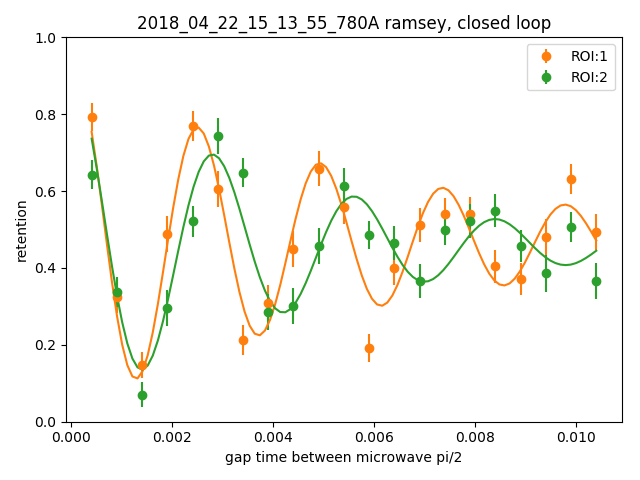

tau 1  is  0.00642363602264  with 1 std of   0.00144800366801
amplitude 1  is  0.437670953579  with 1 std of   0.0589435403973
frequency 1  is  411.810247558  with 1 std of   5.26940749496
phase 1  is  1.34258605405  with 1 std of   0.127544496317
offset 1  is  0.469594173169  with 1 std of   0.0133642891669
tau 2  is  0.00453974635409  with 1 std of   0.00117858966588
amplitude 2  is  0.44115337546  with 1 std of   0.0804043334992
frequency 2  is  357.256330233  with 1 std of   8.69818019072
phase 2  is  1.48384680841  with 1 std of   0.167817866635
offset 2  is  0.458225764282  with 1 std of   0.0155858198574
2018_04_22_15_37_22_780A ramsey, closed loop
60


<IPython.core.display.Javascript object>


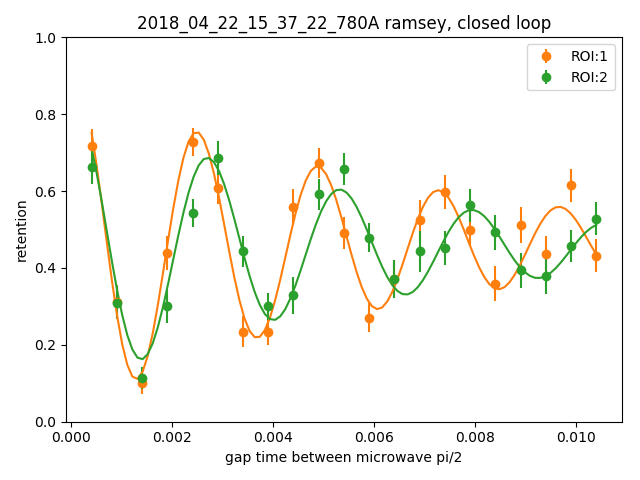

tau 1  is  0.00654203512414  with 1 std of   0.00121639250035
amplitude 1  is  0.427757098535  with 1 std of   0.0469630562638
frequency 1  is  417.732409217  with 1 std of   4.31183444325
phase 1  is  1.28919223083  with 1 std of   0.105781810958
offset 1  is  0.461689546226  with 1 std of   0.0108167441182
tau 2  is  0.00604230909244  with 1 std of   0.00118854707465
amplitude 2  is  0.366129345792  with 1 std of   0.0448915528418
frequency 2  is  381.605545696  with 1 std of   5.25256216941
phase 2  is  1.32984995154  with 1 std of   0.121547100479
offset 2  is  0.452768371558  with 1 std of   0.0102575678294
2018_04_22_16_07_54_780A ramsey, closed loop
61


<IPython.core.display.Javascript object>

tau 1  is  0.0190878213166  with 1 std of   0.0238582704593
amplitude 1  is  0.205086743029  with 1 std of   0.0708537353815
frequency 1  is  411.825778445  with 1 std of   9.49538131337
phase 1  is  1.38605151061  with 1 std of   0.324002283647
offset 1  is  0.406692018376  with 1 std of   0.0205658831831
tau 2  is  0.00394836921404  with 1 std of   0.00112854348393
amplitude 2  is  0.414744397459  with 1 std of   0.0889091612203
frequency 2  is  356.157932112  with 1 std of   10.277464196
phase 2  is  1.74297147466  with 1 std of   0.172918831503
offset 2  is  0.456324775119  with 1 std of   0.0151595065883
2018_04_22_16_41_00_780A ramsey, closed loop
62


<IPython.core.display.Javascript object>


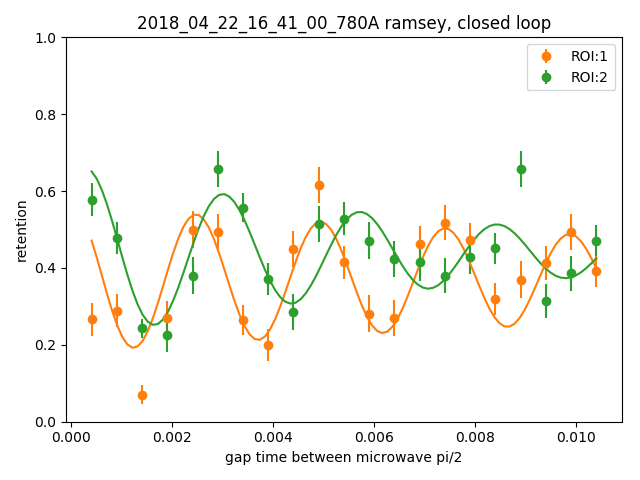

tau 1  is  0.0203830234034  with 1 std of   0.0261472222619
amplitude 1  is  0.190110936011  with 1 std of   0.0641876010554
frequency 1  is  405.156303272  with 1 std of   9.0036728671
phase 1  is  1.55671828673  with 1 std of   0.306615467278
offset 1  is  0.371106182575  with 1 std of   0.0185208261452
tau 2  is  0.0076311990044  with 1 std of   0.00403517578569
amplitude 2  is  0.23042339625  with 1 std of   0.0637900223618
frequency 2  is  368.310560371  with 1 std of   11.6943516743
phase 2  is  0.85520292327  with 1 std of   0.317073538452
offset 2  is  0.437197579439  with 1 std of   0.0170172985813
2018_04_22_17_47_18_780A ramsey, closed loop
63


<IPython.core.display.Javascript object>


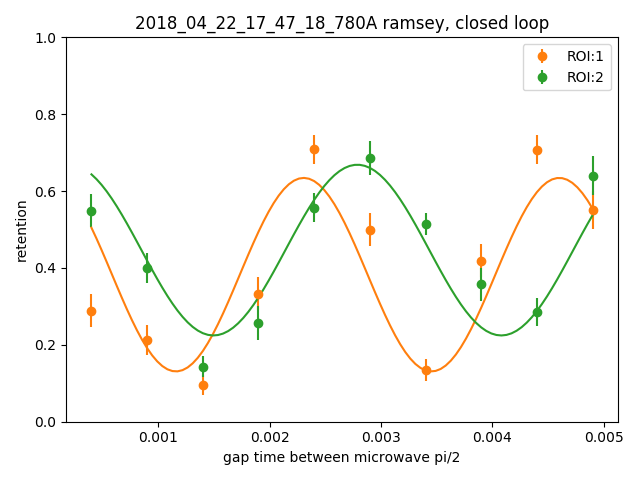

tau 1  is  55163.8019824  with 1 std of   370815327859.0
amplitude 1  is  0.251732239534  with 1 std of   0.142359932411
frequency 1  is  435.751984943  with 1 std of   31.6016823687
phase 1  is  1.54000131257  with 1 std of   0.589698327323
offset 1  is  0.382581817945  with 1 std of   0.0525851566488
tau 2  is  8784.27521416  with 1 std of   6836321766.71
amplitude 2  is  0.222093285888  with 1 std of   0.0949832229263
frequency 2  is  386.793397078  with 1 std of   23.3086394096
phase 2  is  1.07846885819  with 1 std of   0.456186282938
offset 2  is  0.446496332826  with 1 std of   0.0341673537634
2018_04_22_19_38_12_780A ramsey, closed loop
64


<IPython.core.display.Javascript object>


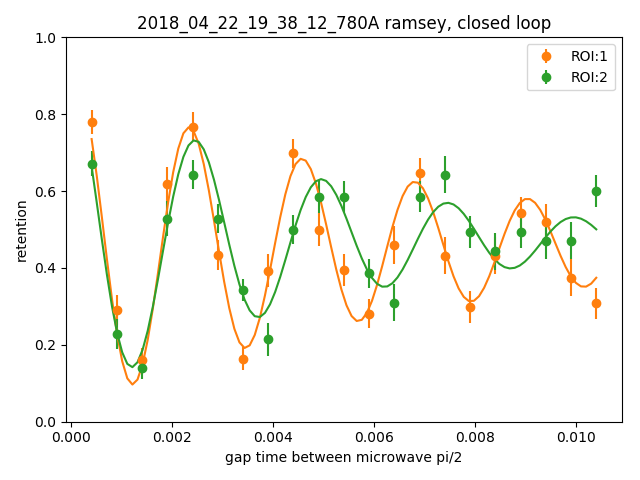

tau 1  is  0.00731721988668  with 1 std of   0.00136567810905
amplitude 1  is  0.425521072366  with 1 std of   0.0447980404529
frequency 1  is  447.36664879  with 1 std of   4.06381495344
phase 1  is  1.2538358051  with 1 std of   0.103321751133
offset 1  is  0.456786135715  with 1 std of   0.0108089178721
tau 2  is  0.00504009715139  with 1 std of   0.00125965611631
amplitude 2  is  0.422037624806  with 1 std of   0.0721823445641
frequency 2  is  399.745066979  with 1 std of   7.19919460169
phase 2  is  1.62680293  with 1 std of   0.145749425857
offset 2  is  0.473611270289  with 1 std of   0.0141948957294
2018_04_22_20_20_07_780A ramsey, closed loop
65


<IPython.core.display.Javascript object>


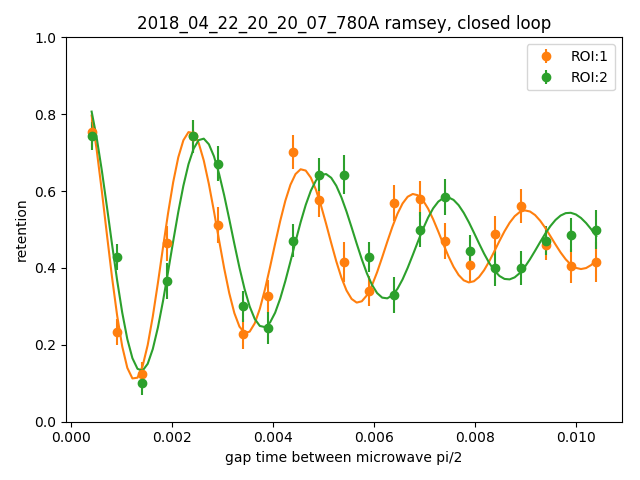

tau 1  is  0.00536860112225  with 1 std of   0.000779649039876
amplitude 1  is  0.450199512505  with 1 std of   0.0419909941215
frequency 1  is  452.050662373  with 1 std of   4.41850510156
phase 1  is  1.09139406404  with 1 std of   0.0971394062108
offset 1  is  0.465650730315  with 1 std of   0.00932958663699
tau 2  is  0.00582798950544  with 1 std of   0.000974772548429
amplitude 2  is  0.424219532924  with 1 std of   0.043454504864
frequency 2  is  412.665012739  with 1 std of   4.65270540923
phase 2  is  1.0678014456  with 1 std of   0.108957345177
offset 2  is  0.465897857187  with 1 std of   0.0100731011805
2018_04_22_20_52_17_780A ramsey, closed loop
66


<IPython.core.display.Javascript object>


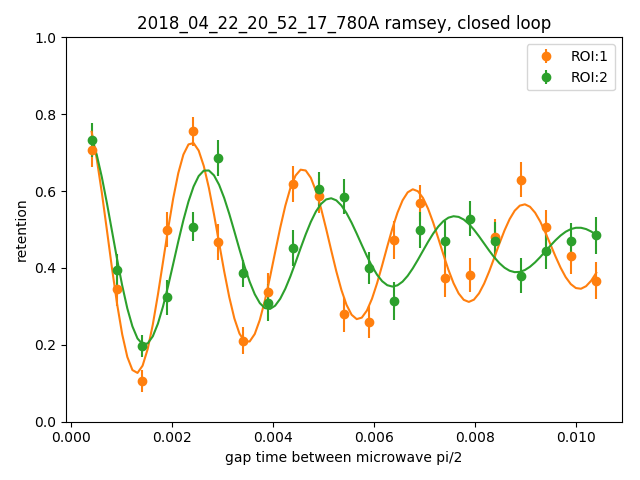

tau 1  is  0.00765942694956  with 1 std of   0.00146667089216
amplitude 1  is  0.380708969138  with 1 std of   0.0390514122507
frequency 1  is  455.537754905  with 1 std of   4.1151439318
phase 1  is  0.983943658995  with 1 std of   0.109302595116
offset 1  is  0.447761064123  with 1 std of   0.00997884861108
tau 2  is  0.00540019711068  with 1 std of   0.00115196108714
amplitude 2  is  0.331762300345  with 1 std of   0.0444901604676
frequency 2  is  407.042556197  with 1 std of   6.82274640139
phase 2  is  0.937720710424  with 1 std of   0.153177754068
offset 2  is  0.45350259768  with 1 std of   0.0103983093148
2018_04_22_21_20_20_780A ramsey, closed loop
67


<IPython.core.display.Javascript object>


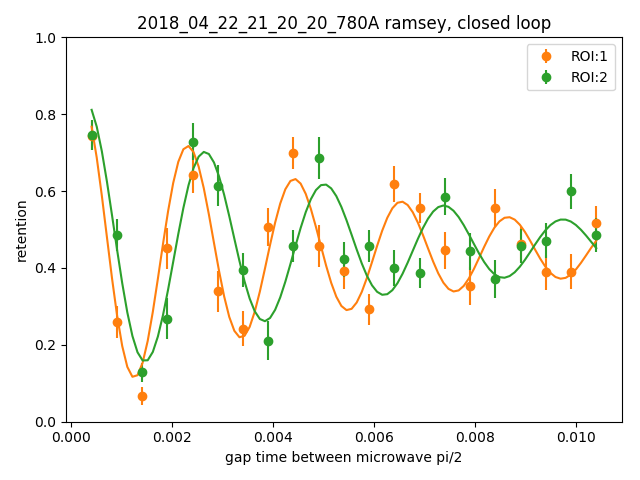

tau 1  is  0.00559533880676  with 1 std of   0.00142916099267
amplitude 1  is  0.412597823459  with 1 std of   0.0654537825173
frequency 1  is  472.567201938  with 1 std of   7.51057354026
phase 1  is  0.956305614962  with 1 std of   0.171735352082
offset 1  is  0.44467132576  with 1 std of   0.0151712511091
tau 2  is  0.00555895931871  with 1 std of   0.00145803316125
amplitude 2  is  0.392911628548  with 1 std of   0.0626688138656
frequency 2  is  422.563749345  with 1 std of   8.02705596412
phase 2  is  0.773716699909  with 1 std of   0.186692301673
offset 2  is  0.458464800996  with 1 std of   0.015062282862
2018_04_22_21_51_16_780A ramsey, closed loop
68


<IPython.core.display.Javascript object>

tau 1  is  0.00708651783553  with 1 std of   0.00335918383589
amplitude 1  is  0.360203074708  with 1 std of   0.0673788565978
frequency 1  is  466.477012831  with 1 std of   10.4712304417
phase 1  is  1.09119960541  with 1 std of   0.193019923992
offset 1  is  0.421066788884  with 1 std of   0.0183631945035
tau 2  is  0.0030900474446  with 1 std of   0.000573822183161
amplitude 2  is  0.587026221998  with 1 std of   0.0745620809689
frequency 2  is  413.743648344  with 1 std of   9.53530625332
phase 2  is  1.26825847255  with 1 std of   0.126477622935
offset 2  is  0.427619318875  with 1 std of   0.0149076572115
2018_04_22_22_10_44_780A ramsey, closed loop
69


<IPython.core.display.Javascript object>


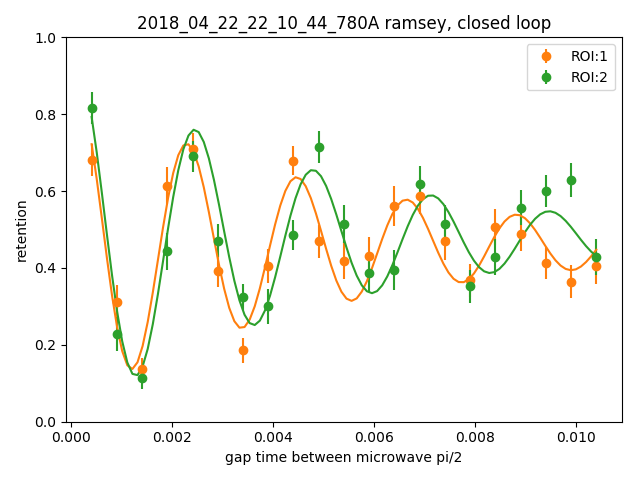

tau 1  is  0.00544623749801  with 1 std of   0.00113864105622
amplitude 1  is  0.402210176189  with 1 std of   0.0538975359208
frequency 1  is  459.159454238  with 1 std of   5.95354415698
phase 1  is  1.20798303194  with 1 std of   0.131558203973
offset 1  is  0.459298189494  with 1 std of   0.0117107921313
tau 2  is  0.00507916914988  with 1 std of   0.00121506037718
amplitude 2  is  0.45981516907  with 1 std of   0.0729741279404
frequency 2  is  427.136411133  with 1 std of   7.45469391114
phase 2  is  1.22877897743  with 1 std of   0.157473191604
offset 2  is  0.476430606737  with 1 std of   0.015461004674
2018_04_22_22_40_55_780A ramsey, closed loop
70


<IPython.core.display.Javascript object>


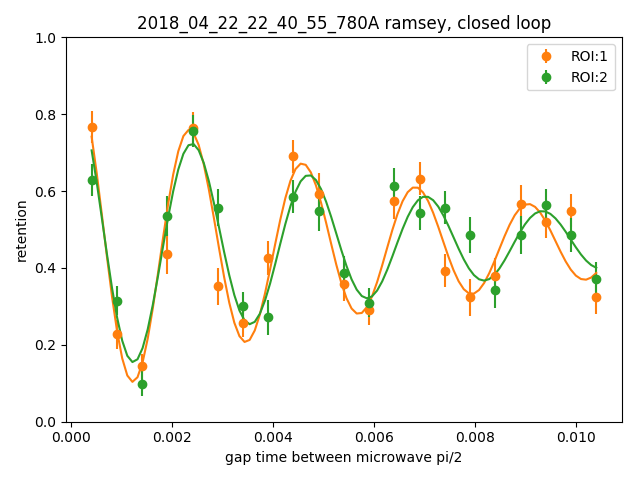

tau 1  is  0.00652465558052  with 1 std of   0.00163520133941
amplitude 1  is  0.42943520799  with 1 std of   0.0644831276075
frequency 1  is  446.698299504  with 1 std of   6.13754557367
phase 1  is  1.24615993874  with 1 std of   0.147733860275
offset 1  is  0.45951162457  with 1 std of   0.014991462703
tau 2  is  0.00606754904778  with 1 std of   0.00168528670878
amplitude 2  is  0.381901362657  with 1 std of   0.0663328301282
frequency 2  is  431.864837042  with 1 std of   7.23694648489
phase 2  is  1.32141008055  with 1 std of   0.16688206631
offset 2  is  0.466203333532  with 1 std of   0.0148691695847
2018_04_22_23_08_42_780A ramsey, closed loop
71


<IPython.core.display.Javascript object>


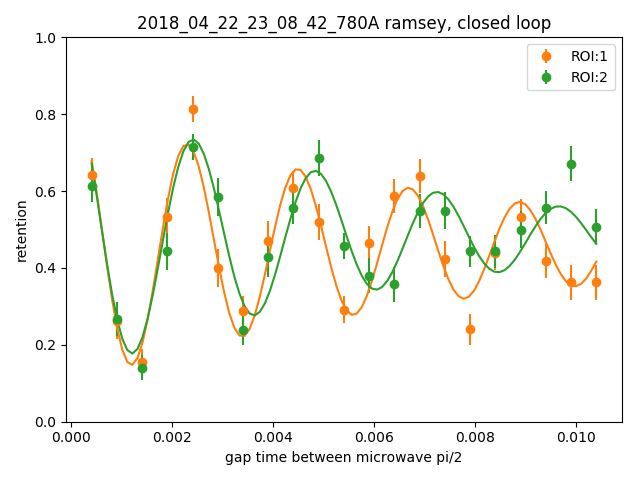

tau 1  is  0.00797952018508  with 1 std of   0.00232971810279
amplitude 1  is  0.356781555963  with 1 std of   0.0552922248359
frequency 1  is  455.119712145  with 1 std of   5.59093430551
phase 1  is  1.27500864228  with 1 std of   0.149117711487
offset 1  is  0.454614698718  with 1 std of   0.0135824049277
tau 2  is  0.00616547690975  with 1 std of   0.00175341896087
amplitude 2  is  0.372183540516  with 1 std of   0.0654315710955
frequency 2  is  413.87198934  with 1 std of   6.65477276461
phase 2  is  1.52911124054  with 1 std of   0.154979742541
offset 2  is  0.4830461533  with 1 std of   0.0141508368224
2018_04_23_08_26_03_780A ramsey, closed loop
72


<IPython.core.display.Javascript object>


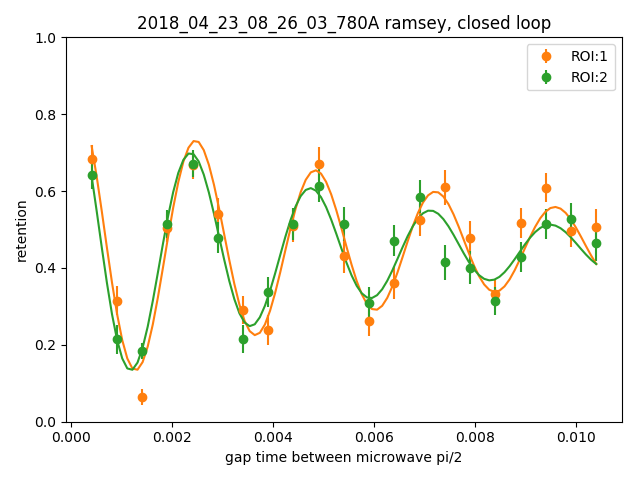

tau 1  is  0.007156380041  with 1 std of   0.00166889974849
amplitude 1  is  0.387126833009  with 1 std of   0.0510334569317
frequency 1  is  421.228630559  with 1 std of   4.96777356111
phase 1  is  1.29427692365  with 1 std of   0.126911343704
offset 1  is  0.457395655807  with 1 std of   0.0121211102812
tau 2  is  0.00523776752554  with 1 std of   0.00107568300794
amplitude 2  is  0.394581794999  with 1 std of   0.0543753745053
frequency 2  is  421.128460986  with 1 std of   5.75811181777
phase 2  is  1.53696888618  with 1 std of   0.120475102079
offset 2  is  0.448401165953  with 1 std of   0.0109982715861
2018_04_23_08_59_01_780A ramsey, closed loop
73


<IPython.core.display.Javascript object>


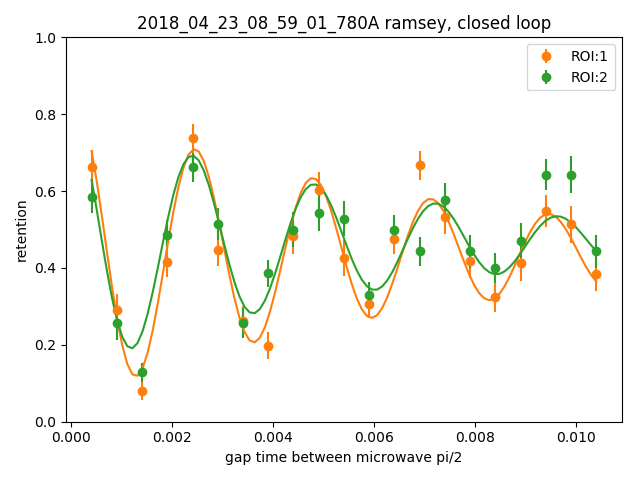

tau 1  is  0.00724392222444  with 1 std of   0.00174657878556
amplitude 1  is  0.381269392414  with 1 std of   0.051892681998
frequency 1  is  427.89990832  with 1 std of   5.26435014685
phase 1  is  1.23777207066  with 1 std of   0.134511031434
offset 1  is  0.437517783777  with 1 std of   0.0125438701792
tau 2  is  0.00602519938099  with 1 std of   0.00208406896518
amplitude 2  is  0.336751791232  with 1 std of   0.0730267225117
frequency 2  is  414.808330329  with 1 std of   8.25666432248
phase 2  is  1.55879292323  with 1 std of   0.189115492203
offset 2  is  0.466645771537  with 1 std of   0.015587350265
2018_04_23_09_30_44_780A ramsey, closed loop
74


<IPython.core.display.Javascript object>


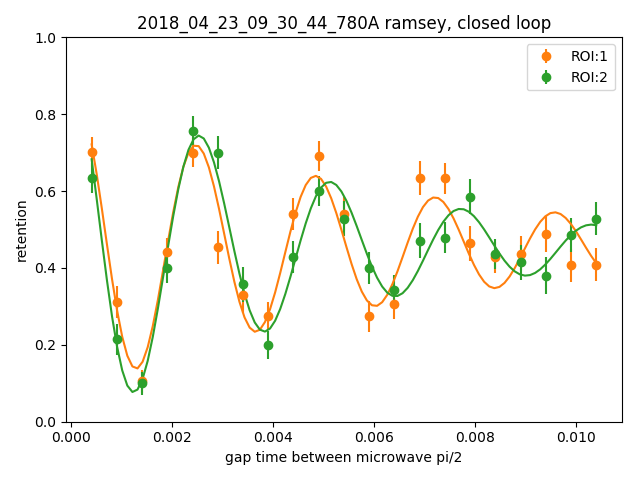

tau 1  is  0.00657242244872  with 1 std of   0.00175293154237
amplitude 1  is  0.386068459103  with 1 std of   0.0607516387398
frequency 1  is  422.127891706  with 1 std of   6.25600915697
phase 1  is  1.25726859675  with 1 std of   0.153639564053
offset 1  is  0.455007896823  with 1 std of   0.0141182645826
tau 2  is  0.00481488374917  with 1 std of   0.000656501480673
amplitude 2  is  0.490562513968  with 1 std of   0.0471074280265
frequency 2  is  385.793537351  with 1 std of   4.2533093611
phase 2  is  1.6440801623  with 1 std of   0.0826248704017
offset 2  is  0.455312494892  with 1 std of   0.00915906517491


In [4]:
save_figures=False
data11 = []
for n in range(0,len(assorted['exp_ids'])):    
    print assorted['exp_ids'][n]
    assorted_roi3freqs=[]
    assorted_roi2freqs=[]
    assorted_roi3perr=[]
    assorted_roi2perr=[]
    i = n
    print i
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()


    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    fit_guesses=[0.016, 0.35, 410 ,1.3, 0.45]
    fit_guesses2=[0.016, 0.3, 410 ,1.3, 0.45]
    #roi_dependency=[0,0,0,0,0]
    fitted_parameters=[]
    freqarray = []
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []

        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
        #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
        #try:
       # decaying_sin(t,tau,amp,freq,phase,offset)
        try:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offset',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

        except:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offsett',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

           #fit2,pcov2 = curve_fit(gaussian,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
       # except RuntimeError:
       #     error=1
    #     if error is not 1:
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit2[0],fit2[1],fit2[2])

        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=decaying_sin(xarray, fit[0], fit[1], fit[2], fit[3],fit[4])
        plt.plot(xarray,yfit,color=colors[roi])
           # yfit2=gaussian(xarray, fit2[0], fit2[1], fit2[2], fit2[3])
            #plt.plot(xarray,yfit,label="mj=5/2", color=colors[0])
            #plt.plot(xarray,yfit2,label="mj=3/2", color=colors[1])

    #         if roi==3:
    #             assorted_roi3freqs.append(fit[2])
    #             assorted_roi3perr.append(np.sqrt(pcov[2][2]))
    #         elif roi==2:
    #             assorted_roi2freqs.append(fit[2])
    #             assorted_roi2perr.append(np.sqrt(pcov[2][2]))

    ax.set_title(exp_id)
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.legend()
    plt.tight_layout()
    plt.show()
    if save_figures:
        plt.savefig('{}.pdf'.format(exp_id))
    
    
    
    starting_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][0])).strftime('%Y-%m-%d %H:%M:%S')
    end_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][len(assorted['timestamps'][i])-1])).strftime('%Y-%m-%d %H:%M:%S')
    middle_time = dt.datetime.fromtimestamp(int((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 )).strftime('%H:%M')
    time_length = (assorted['timestamps'][i][len(assorted['timestamps'][i])-1])-assorted['timestamps'][i][0]
    time_from_data_start = ((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 ) - assorted['timestamps'][0][0] 
    data11.append([ starting_time,end_time,freqarray[0],freqarray[1],freqarray[2],freqarray[3],middle_time,time_length,time_from_data_start])



In [43]:
off_data=[]
offtimestamps=[]
for i in range(0,len(assorted['exp_ids'])):
   # print 'Relative AC stark shift (r1/r2) = {:.3f} (and put uncertainty here)'.format(data11[i][2]/data11[i][4])
    if data11[i][2]/data11[i][4] > 2 or data11[i][2]/data11[i][4] < 0.5:
        off_data.append(data11[i][2]/data11[i][4])
        
        offtimestamps.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    else:
        off_data.append(np.nan)
        offtimestamps.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))

<IPython.core.display.Javascript object>


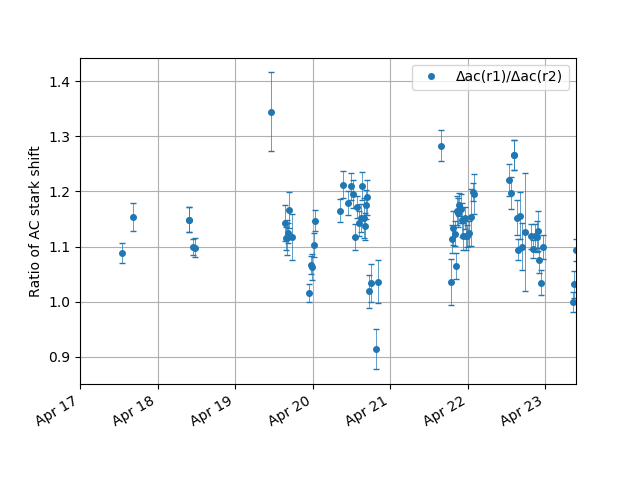

<IPython.core.display.Javascript object>


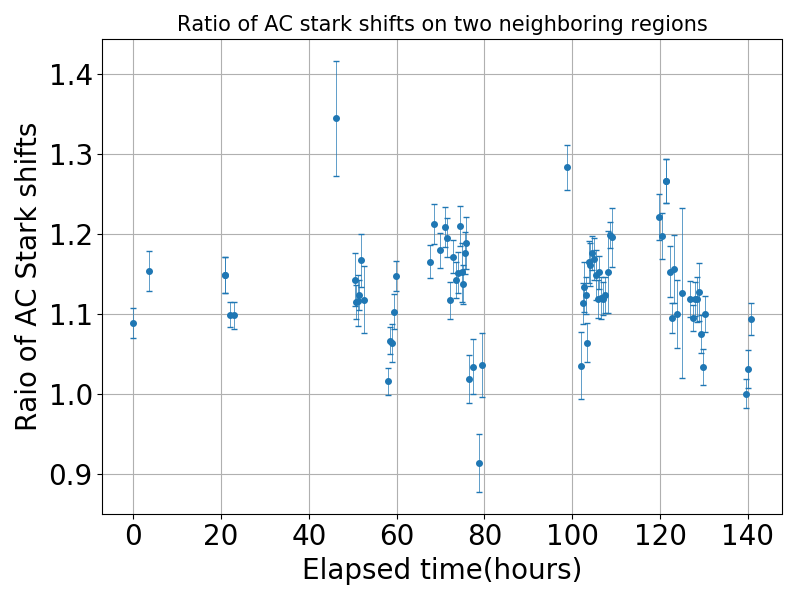

In [44]:

ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
startingtime_in_UNIX=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    startingtime_in_UNIX.append(assorted['timestamps'][i][0])
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])

#samplerate='2S'
df=pd.DataFrame({  "Δac(r1)/Δac(r2)": ratio_data,'timestamps': avetimestamp,'error': ratio_error,'off_data': off_data},index=startingtime)

ax=df.plot(y=[ "Δac(r1)/Δac(r2)"],yerr='error',capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',color=['#1f77b4', '#d62728'])
days=md.DayLocator()
hours=md.HourLocator()
ax.set_xlim(dt.datetime(2018,4,17))
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('Ratio of AC stark shift')
ax.grid()
#plt.savefig('Alignment_20180415.png')

timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
#ax.set_ylim(-0.3,0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='AC Stark shift ratios'
plt.savefig(filename+'.png')
plt.savefig(filename+'.pdf')
plt.savefig(filename+'.eps')

In [45]:

ROI1_ac=[]
ROI1_err=[]
ROI2_ac=[]
ROI2_err=[]
avetimestamp=[]
timelength=[]
startingtime=[]
ROI_err=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ROI1_ac.append(data11[i][2])
    ROI_err.append([data11[i][3],data11[i][5]])
   # ROI_err.append(data11[i][3])
   # ROI_err.append(data11[i][5])
    ROI1_err.append(data11[i][3])
    ROI2_ac.append(data11[i][4])
    ROI2_err.append(data11[i][5])
    #ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
 
# Using Pandas

df2=pd.DataFrame({  "Δac(r1)": ROI1_ac,'Δac(r2)':ROI2_ac,'timestamps': avetimestamp,'ROI_err': ROI_err},index=startingtime)

ax=df2.plot(y=[ "Δac(r1)"],yerr=ROI1_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax.set_xlim(dt.datetime(2018,4,17))
ax.xaxis.set_major_locator(days)
#ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('AC stark shift')
ax.grid()

ax2=df2.plot(y=[ "Δac(r2)"],yerr=ROI2_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax2.set_xlim(dt.datetime(2018,4,17))
ax2.xaxis.set_major_locator(days)
ax2.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax2.set_ylabel('AC stark shift')
ax2.grid()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
peakshift = 825
wx = 6.3
spacing = 9.25
xx = np.arange(-10.0, 10.0, 0.1)
# fig, ax = plt.subplots()
# plt.plot(xx,gaussian(xx,peakshift,-spacing/2,wx,0))
# plt.plot(xx,gaussian(xx,peakshift,spacing/2,wx,0))
# plt.show()

# fig, ax = plt.subplots()
# xxx = np.arange(-.3, 0.3, 0.005)
# plt.plot(xxx,(gaussian(xxx,peakshift,spacing/2,wx,0)/gaussian(xxx,peakshift,-spacing/2,wx,0)))
# plt.show()


In [47]:
def gaussian2(x,amp,x0,sigma,offset):
    res=(amp*sp.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res
#print gaussian(4,peakshift,spacing/2,wx,0)
#x=Symbol('x')
#print gaussian(y,peakshift,spacing/2,wx,0)
#print solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-1.1,x)


ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
avetimestamp=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
#print error_total
ratio_to_dist=[]  
x=Symbol('x')
dist_max_error=[]
dist_min_error=[]
error_all=[]
for z in range(0,len(ratio_error)):
    center_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z],x)
    max_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]-ratio_error[z],x)
    min_val =  solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]+ratio_error[z],x)
    ratio_to_dist.append(np.float(center_val[0]))
    maxerr = max_val[0] - center_val[0]
    minerr = center_val[0]- min_val[0]
    dist_max_error.append(np.float(maxerr))
    dist_min_error.append(np.float(minerr))
    error_all.append([np.float(maxerr),np.float(minerr)])

In [48]:
df4=pd.DataFrame({ "beam displacment": ratio_to_dist,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df4.plot(y=["beam displacment"],yerr=[dist_max_error,dist_min_error],capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from r1-r2 center (um)')
ax.set_xlim(dt.datetime(2018,4,17))
ax.grid()

<IPython.core.display.Javascript object>

In [49]:
start_offset=np.mean(ratio_to_dist[0]) # Off
displacement_frombias=ratio_to_dist-start_offset
df5=pd.DataFrame({"Displacment from the bias point":displacement_frombias ,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df5.plot(y=["Displacment from the bias point"],yerr=[dist_max_error,dist_min_error],capsize=2,lw=1,marker='o',alpha=0.7,linestyle='None',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from the bias(um)')
ax.set_xlim(dt.datetime(2018,4,17))
ax.set_ylim(-0.3,0.3)
#days=md.DayLocator()
#ax.xaxis.set_major_locator(days)
#ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))

ax.grid()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


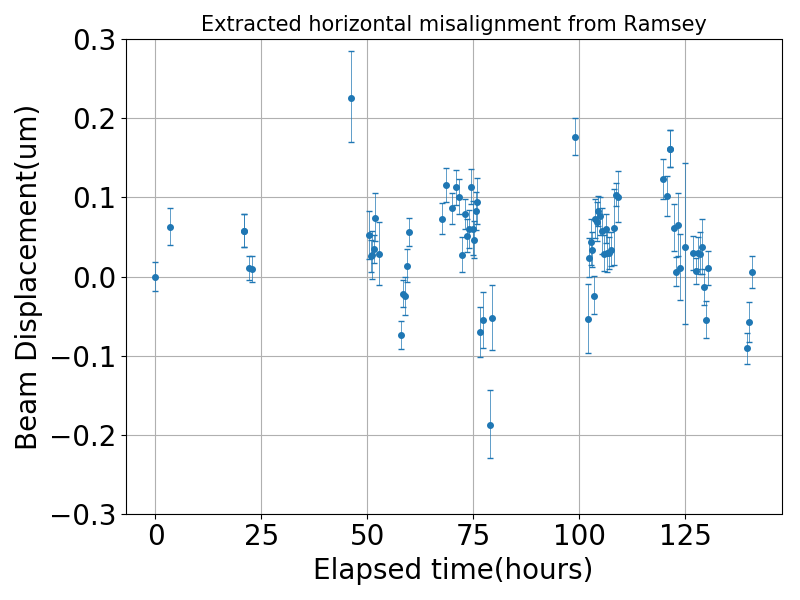

In [50]:
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Beam Displacement(um)',fontsize=20)
ax.set_title('Extracted horizontal misalignment from Ramsey',fontsize=15)
ax.set_ylim(-0.3,0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Extracted_horizontal_misalignment_from_Ramsey'
plt.savefig(filename+'.png')
plt.savefig(filename+'.pdf')
plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


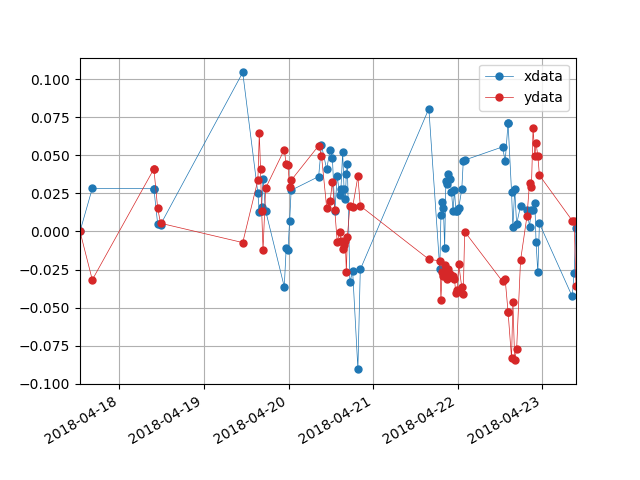

<IPython.core.display.Javascript object>


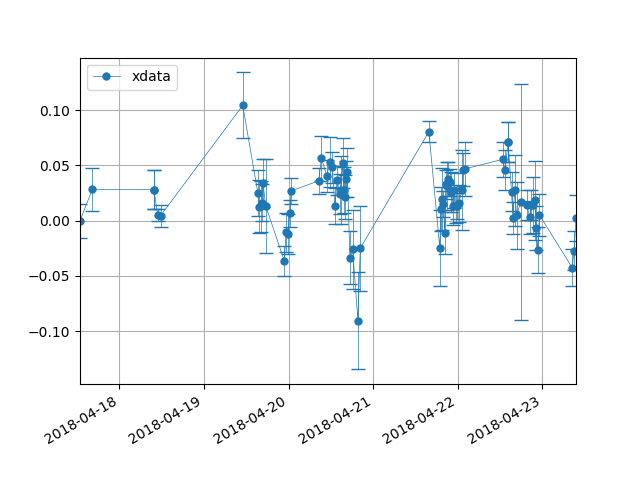

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
x_data=[]
y_data=[]
x_error=[]
y_error=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    x_data.append(0.5*(data11[i][2]/data11[0][2]-data11[i][4]/data11[0][4]))
    y_data.append((0.5*(data11[i][2]/data11[0][2]+data11[i][4]/data11[0][4]))-1.0)
    xerror=np.sqrt((1/data11[0][2]*data11[i][3])**2+(((-1/data11[0][4])*data11[i][3])**2))
    yerror=np.sqrt((1/data11[0][2]*data11[i][3])**2+(((1/data11[0][4])*data11[i][3])**2))
    x_error.append(xerror)
    y_error.append(yerror)
    avetimestamp.append(data11[i][6])
    
df=pd.DataFrame({  "xdata": x_data, "ydata": y_data,'timestamps': avetimestamp,'xerror': x_error,'yerror': y_error},index=startingtime)
ax=df.plot(y=[ "xdata","ydata"],lw=0.5,marker='o',markersize=5,color=[ '#1f77b4','#d62728'])
ax.grid()
ax=df.plot(y=[ "xdata"],yerr='xerror',capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
ax.grid()
ax=df.plot(y=[ "ydata"],yerr='yerror',capsize=5,lw=0.5,marker='o',markersize=5,color=[ '#d62728'])
ax.grid()
ax=df.plot(x=[ "xdata"],y=["ydata"],lw=0,marker='.',markersize=10,color=[ '#1f77b4','#d62728'])
ax.grid()

# TIME SERIES ANALYSES

In [52]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
         'AAS_redside',
         'AAS_blueside',
 'timestamp_measurements',
 'timestamp_iteration']

data={}
for j in range(0,len(exp_ids)):
    exp_id=exp_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)
    

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_12_52_32_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_16_21_34_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_18/2018_04_18_09_49_23_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_18/2018_04_18_09_49_23_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_18/2018_04_18_10_54_00_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_18/2018_04_18_11_42_28_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_19/2018_04_19_11_01_05_780A ramsey, closed loop/qdp.txt
Yay! found old qdp class. We

<IPython.core.display.Javascript object>


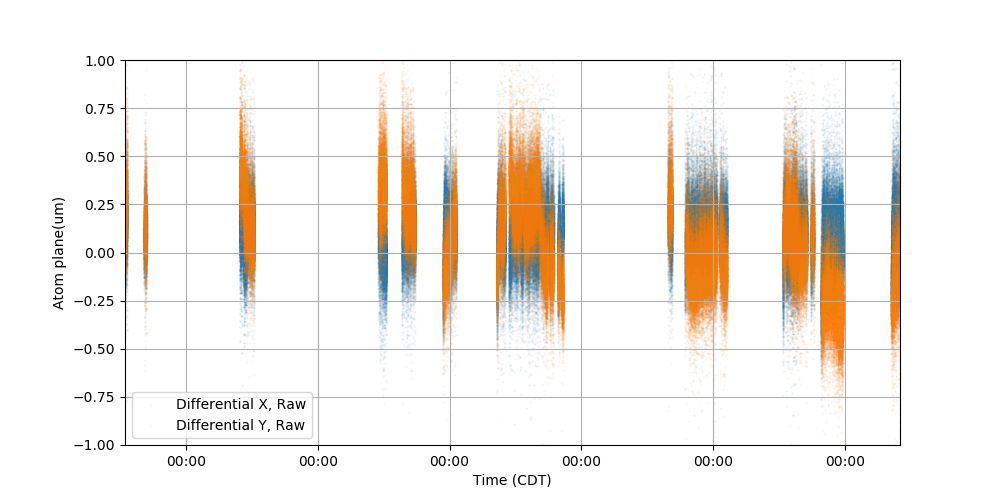

In [53]:
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=0.2,alpha=0.1,label='Differential X, Raw')
ax.set_xlim(dates[0],dates[-1])
ax.set_ylim(-1,1)

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=0.2,alpha=0.1,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
if savefig:   
    plt.savefig('Alignment_over_night.png')

<IPython.core.display.Javascript object>


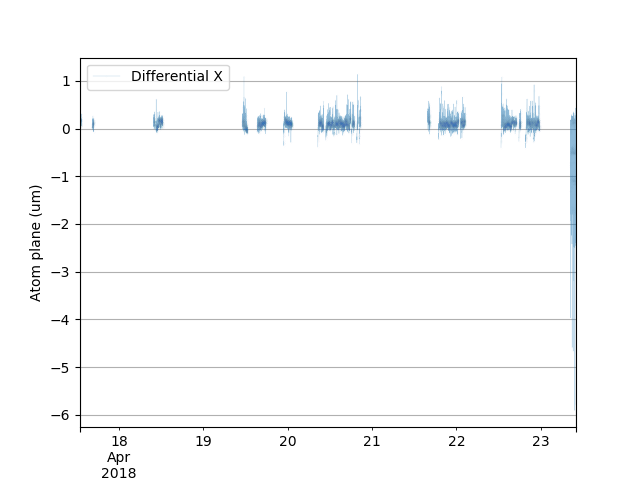

<IPython.core.display.Javascript object>


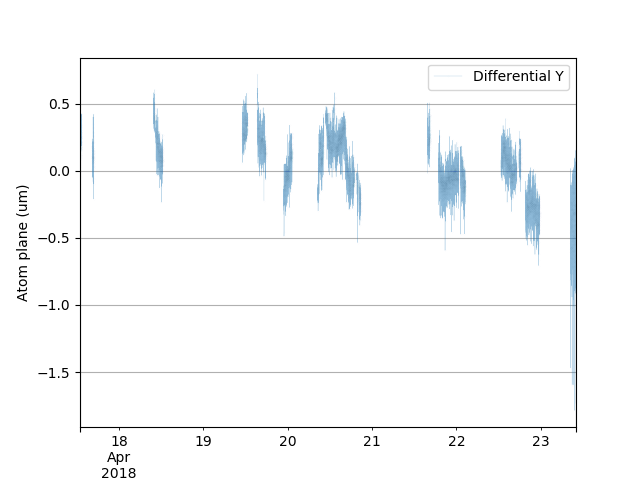

In [54]:
# Using Pandas
import pandas as pd
savefig=False
data_cutoff=0
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

samplerate='10S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY,
                 'Red X': flatteneddata0,
                 'Red Y': flatteneddata1,
                 'FORT X': flatteneddata2,
                 'FORT Y': flatteneddata3
                },index=dates)

## 
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Differential X'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Differential Y'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

1526
1526


<IPython.core.display.Javascript object>


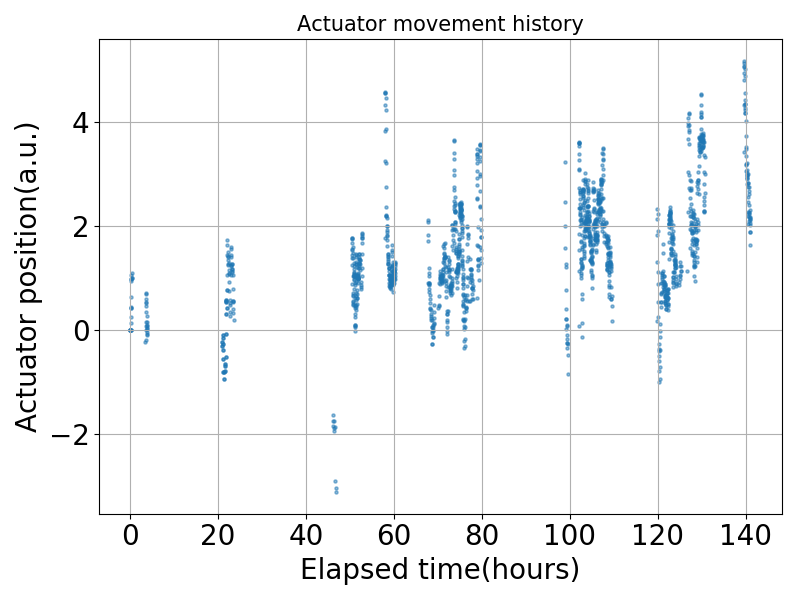

250
663
1125
1303


<IPython.core.display.Javascript object>


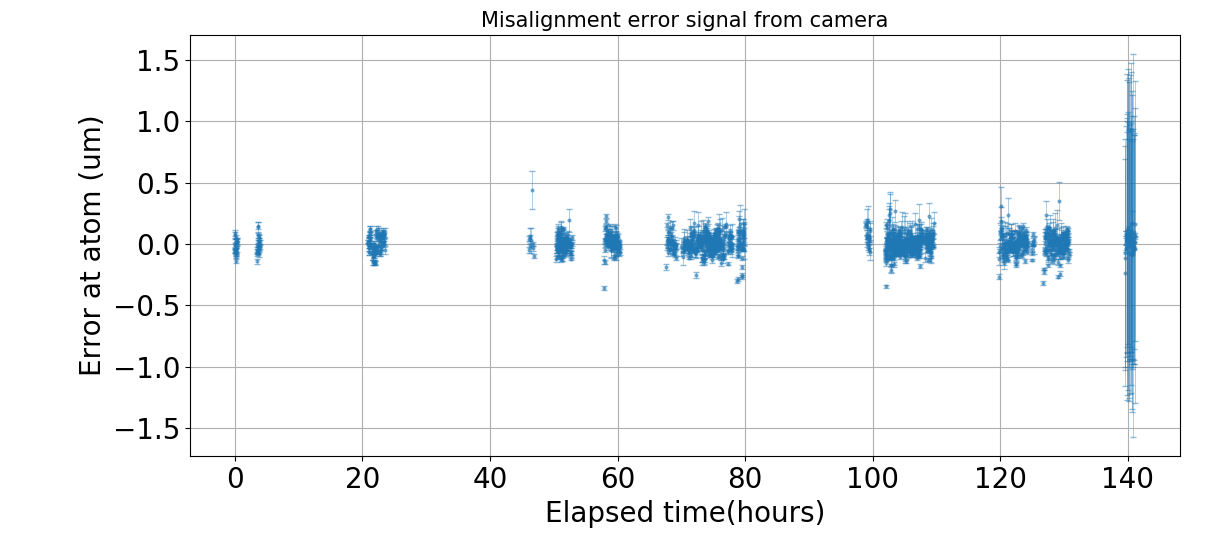

In [55]:
## Actuator Plot
actuator_x=[]
i=0
assorted['qdp_class'][0].experiments[0]['iterations']
for q in assorted['qdp_class']:
    #print q
    #print exp_ids[i]
    for iter in q.experiments[0]['iterations']:
        value=q.experiments[0]['iterations'][iter]['variables']['Corrected_Red_X']
        actuator_x.append(value)
    #    print value
    i=i+1

elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

print np.size(elapsed_time_in_hours)
print np.size(actuator_x)

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_x-actuator_x[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator X History'
plt.savefig(filename+'.png')
plt.savefig(filename+'.pdf')
plt.savefig(filename+'.eps')

## Camera error signal
camera_error_x=[]
camera_error_sigma_x=[]

samples=25
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_x.append(data[keylist[4]][i]['error_x']/calibration_factor)
        camera_error_sigma_x.append(data[keylist[4]][i]['sigma_x']/math.sqrt(samples))
    except:
        print i
        camera_error_x.append(np.nan)
        camera_error_sigma_x.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS X History'
plt.savefig(filename+'.png')
plt.savefig(filename+'.pdf')
plt.savefig(filename+'.eps')




In [68]:
print camera_error_sigma_x[:10]

[0.022366457123453233, 0.017957683213822077, 0.016673520303527156, 0.010896566530724353, 0.023447849145638775, 0.023818901112417946, 0.039661789093058487, 0.029409117002944941, 0.017024198581215275, 0.02652388326653693]


In [69]:
print camera_error_sigma_x[-10:]

[0.93461530219723321, 0.94611811995916406, 0.028188762006190603, 0.0084322432234944285, 0.93375600333903319, 0.92464350567973663, 0.016677282290155637, 0.01172923078257935, 0.94874268374116899, 1.3136238625734344]


# Figuring out the dead region

<IPython.core.display.Javascript object>


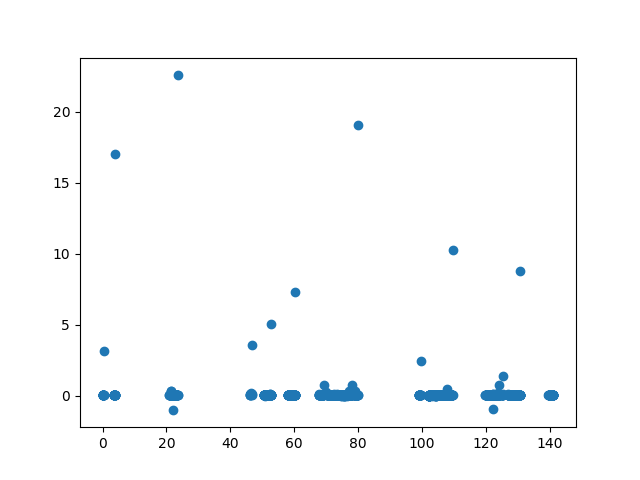

T=0.339105277788, duration of :3.14561166673
T=3.91062527784, duration of :17.0359719444
T=23.52558, duration of :22.6161719445
T=46.8686561112, duration of :3.56329805549
T=52.8426844444, duration of :5.0761591667
T=60.3263791667, duration of :7.33547638886
T=79.8355841667, duration of :19.0801480556
T=99.5770863889, duration of :2.44135527773
T=109.575110278, duration of :10.2257530555
T=130.783055278, duration of :8.77547638887


In [59]:

fig, ax= plt.subplots()
dead_times=elapsed_time_in_hours[1:]-elapsed_time_in_hours[0:-1]
ax.scatter(elapsed_time_in_hours[0:-1],dead_times)
threshold=2
dead_T=[]
dead_duration=[]
for i in range(0,len(dead_times)):
    if dead_times[i]>threshold:
        print 'T={}, duration of :{}'.format(elapsed_time_in_hours[0:-1][i],dead_times[i])
        dead_T.append(elapsed_time_in_hours[0:-1][i])
        dead_duration.append(dead_times[i])

<IPython.core.display.Javascript object>


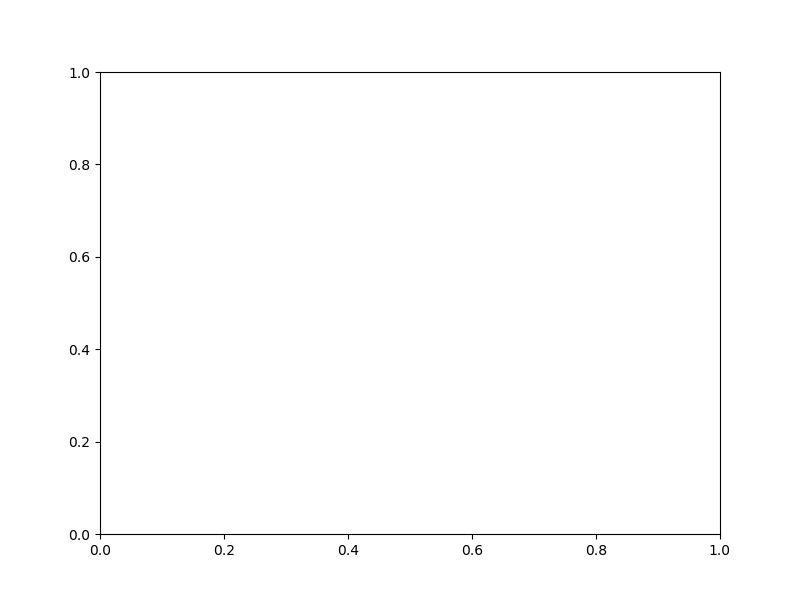

RuntimeError: xdata and ydata must be the same length

In [60]:
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='r')
ax.set_ylim(1.1-0.3,1.1+0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()

# Insert room temperature history

In [61]:
import csv
csvfile=open('ganglia-metrics.csv')
spamreader=csv.reader(csvfile,delimiter=',')
for row in spamreader:
    print ','.join(row)

Timestamp,hexa-netbotz1.physics.wisc.edu 5335a-Temp-Rb-Lab           
2018-04-15T13:30:00-05:00,NaN
2018-04-15T14:00:00-05:00,69.169
2018-04-15T14:30:00-05:00,69.0203
2018-04-15T15:00:00-05:00,68.8368
2018-04-15T15:30:00-05:00,68.8712
2018-04-15T16:00:00-05:00,68.6946
2018-04-15T16:30:00-05:00,68.3897
2018-04-15T17:00:00-05:00,68.5991
2018-04-15T17:30:00-05:00,68.747
2018-04-15T18:00:00-05:00,68.7836
2018-04-15T18:30:00-05:00,68.8162
2018-04-15T19:00:00-05:00,68.835475
2018-04-15T19:30:00-05:00,68.840825
2018-04-15T20:00:00-05:00,68.9007
2018-04-15T20:30:00-05:00,68.8766
2018-04-15T21:00:00-05:00,68.8998
2018-04-15T21:30:00-05:00,68.8105
2018-04-15T22:00:00-05:00,68.8699
2018-04-15T22:30:00-05:00,68.8944
2018-04-15T23:00:00-05:00,68.9576
2018-04-15T23:30:00-05:00,68.9949
2018-04-16T00:00:00-05:00,68.9
2018-04-16T00:30:00-05:00,68.9297
2018-04-16T01:00:00-05:00,68.9287
2018-04-16T01:30:00-05:00,68.978
2018-04-16T02:00:00-05:00,68.9859
2018-04-16T02:30:00-05:00,68.9022
2018-04-16T03:00:0

<IPython.core.display.Javascript object>


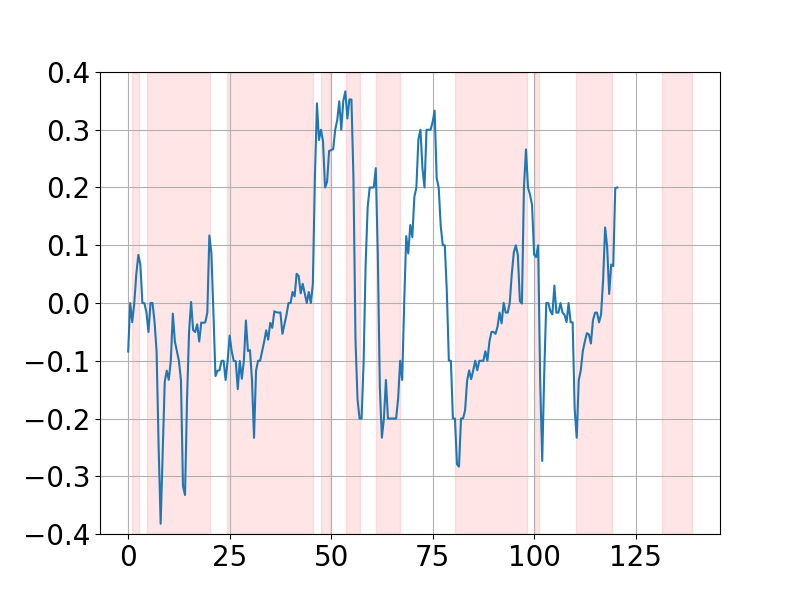

In [70]:
from numpy import genfromtxt
my_data=genfromtxt('ganglia-metrics.csv',delimiter=',')
temperatures_in_F=np.array(my_data[96:,1]) # Selecting data from 2018-04-17 13:00, 30min interval
temperatures_in_C=5.0/9.0*(temperatures_in_F-32.0)
timestamps=np.arange(0,len(temperatures_in_C))*0.5
offset=np.mean(temperatures_in_C)

fig, ax=plt.subplots()
fig.set_size_inches(8,6)
ax.plot(timestamps,temperatures_in_C-offset)
ax.grid()
ax.set_ylim(-0.4,0.4)
ax.tick_params(labelsize=20)

for i in range(0,len(dead_T)):
     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],-0.4,0.4,alpha=0.1,color='r')

<IPython.core.display.Javascript object>


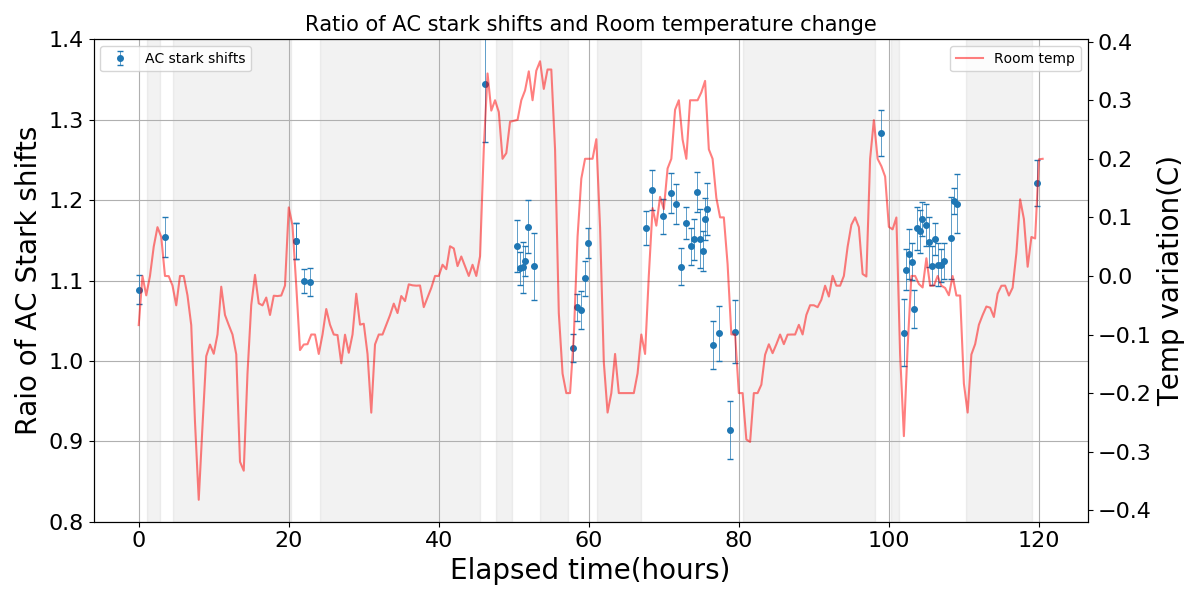

In [43]:
# Together!!
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='AC stark shifts')
ax2=ax.twinx()
ax2.plot(timestamps,temperatures_in_C-offset,color='r',alpha=0.5,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax2.set_ylabel('Temp variation(C)',fontsize=20)
ax.set_title('Ratio of AC stark shifts and Room temperature change',fontsize=15)
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='gray')
ax.set_ylim(1.1-0.3,1.1+0.3)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
filename='20180422_AC_starkshifts and temperature'
plt.savefig(filename+'.png')
plt.savefig(filename+'.pdf')
plt.savefig(filename+'.eps')


<IPython.core.display.Javascript object>


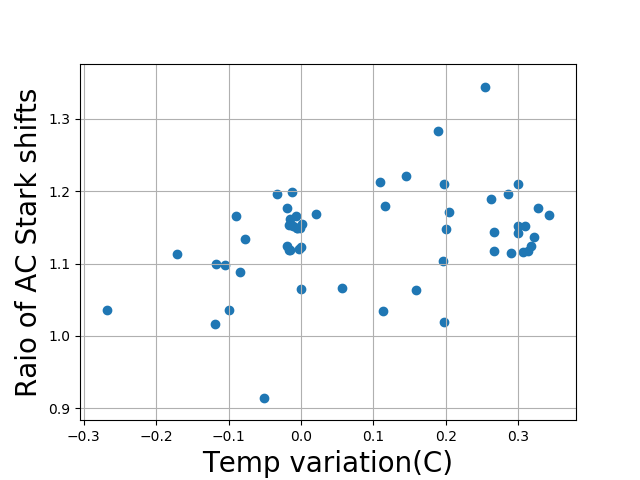

In [52]:
interpolated_temperature=np.interp(timediff,timestamps,temperatures_in_C-offset)
fig, ax=plt.subplots()
ax.scatter(interpolated_temperature,ratio_data)
ax.set_aspect('equal')
ax.set_xlabel('Temp variation(C)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.grid()

# Allan deviation

In [24]:
# Allan 
tau_list=range(1,100)+range(101,1001,10)+range(1002,10002,100)+range(10003,100003,200)+range(100004,400004,1000)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    print '{}'.format(i)
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


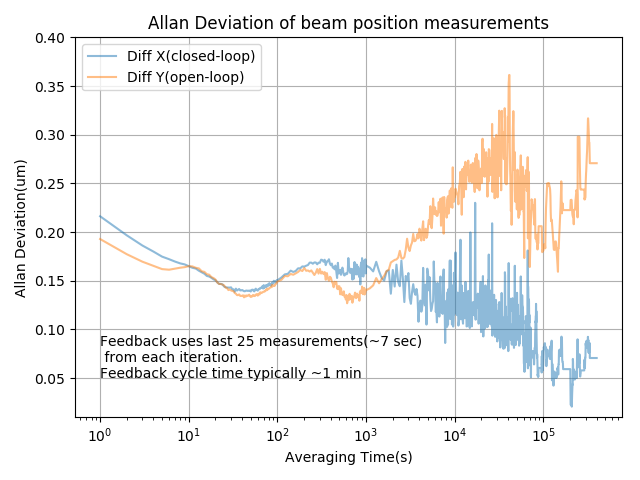

In [34]:
savefig=False
fig, ax = plt.subplots()
#xdata=tau_lists
#for key in var_list:
#i=['Diff X(closed-loop)','Diff Y(open-loop)']
#for key in ['Differential X','Differential Y']:
ax.semilogx(tau_list, np.sqrt(0.5*np.array(var_list['Differential X'])),label='Diff X(closed-loop)',alpha=0.5)
ax.semilogx(tau_list, np.sqrt(0.5*np.array(var_list['Differential Y'])),label='Diff Y(open-loop)',alpha=0.5)
#ax.semilogx(tau_list, np.sqrt(Yvar_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Xvariance_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Yvariance_list),label='Diff Y',alpha=0.5)
ax.legend()
#ax.set_xlim(1,)
ax.set_title('Allan Deviation of beam position measurements')
ax.set_xlabel('Averaging Time(s)')
ax.set_ylabel('Allan Deviation(um)')
ax.text(10**0,0.05,'Feedback uses last 25 measurements(~7 sec)\n from each iteration.\nFeedback cycle time typically ~1 min')
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.01,0.4)
ax.grid()
plt.tight_layout()
filename='20180422_AllanDeviation'
plt.savefig(filename+'.png')
plt.savefig(filename+'.pdf')
plt.savefig(filename+'.eps')


In [26]:
25*0.3

7.5

In [28]:
200*0.3

60.0